In [2]:
import os
import geopandas as gpd
import pandas as pd
import argparse
from geofunctions import utils

In [107]:
freq_users_list = [
    "034f8330-44eb-40b8-a7a8-85162f943394",
    "0353b2c6-fe26-430f-b1bb-6c5cc2a7b3e6",
    "0378b12f-7a5e-49da-9213-a9f187ce4b8e",
    "06819b3d-1bfd-4aa2-8342-0f27ab48dc44",
    "07da8be0-cbf3-4cec-b22e-ea9702d506be",
    "0c7b7e42-fddf-4193-8b46-9e8649a8fcf9",
    "0e2a4c4f-1eb2-42e5-998c-a0d3b7ed7d1f",
    "0ebb5ebc-f573-49d2-ae4d-5de7b5aea5f9",
    "0efd806b-dfad-456e-8ab0-27eefa5f2cc3",
    "0fee1fb7-2c82-41ea-98c3-ebe611b64698",
    "1056ac87-3da4-4577-87c5-4d7c2c3dc4f1",
    "10bb32a1-94da-416d-8b6b-2311255cba27",
    "12af3116-fba8-4da3-80a2-743bd01e59f5",
    "12dc69db-536d-4669-a642-26215a38a02c",
    "14358b70-bd30-4606-9b57-e9c65cedb74b",
    "1447f592-1101-4e92-afcc-7ed4ea4787ad",
    "1769b038-7006-4b9a-948a-9518e332195c",
    "177ac873-54b9-4459-9070-32e1dbf48687",
    "19977e35-b279-45bb-9cbe-55fa5c4157e8",
    "19c4ed77-a2af-46de-8bff-b780a5f1089c",
]

In [97]:
# Read files
months = ['201901','201904','201907','201908','201909','201911','201912','202309'] #utils.return_list_months_ok()
list_months = []
for MONTH in months  :
    print(MONTH)
    df_filtered_good = pd.read_parquet(
        utils.get_path("raw", "dwells", f"data_filtered_{MONTH}.parquet")
    )
    df_filtered_freq = df_filtered_good[
        df_filtered_good.identifier.isin(freq_users_list)
    ]
    if len(df_filtered_freq) > 0:
        df_filtered_dwells = utils.make_gdf(df_filtered_freq, geometry="the_geom")
        df_filtered_dwells["month"] = MONTH
        list_months.append(df_filtered_dwells)

201901
201904
201907
201908
201909
201911
201912
202309
Parsed WKB to geometry


In [98]:
df_freq_full = pd.concat(list_months)

In [ ]:
df_freq_full.shape

(33500, 22)

In [108]:
list_freq_ident_df = []
for MONTH in months:

    work_df_part = pd.read_csv(
        os.path.join(
            utils.get_path("processed", "dwells", "work"),
            f"users_work_home_{MONTH}.csv",
        ),
        index_col=0,
    )
    freq_df = work_df_part[work_df_part.identifier.isin(freq_users_list)]
    freq_df["month"] = MONTH
    list_freq_ident_df.append(freq_df)

In [109]:
df_freq_home_work = pd.concat(list_freq_ident_df)

In [110]:
df_freq_home_work 

Empty DataFrame
Columns: [identifier, date, work_location_date, work_days_with_signals, share_days_work_location, share_workdays_work_location, commuting_distance, home_geometry, geohash_home, night_hours_count, nights_count, rank_night, shabbat_hours_counts, rank_shabbat, weight, rank_weighted, hour_work_home, date_home_all, hour_home_all, date_work_home, hour_work_all, date_work_all, share_work_in_home_hours, share_home_work_hours, share_work_in_home_days, share_home_work_days, share_home_hours_home, flag_frequent_user, geohash_work, month]
Index: []

[0 rows x 30 columns]

In [102]:
df_freq_full_home_work = df_freq_full.merge(
    df_freq_home_work[["identifier", "geohash_home", "geohash_work", "month"]],
    on=["identifier", "month"],
)

In [ ]:
df_freq_full_home_work["flag_type_loc_old"] = df_freq_full_home_work[
    ["geohash_home", "geohash", "geohash_work"]
].apply(
    lambda r: (
        "home"
        if r["geohash_home"] == r["geohash"]
        else ("work" if r["geohash_work"] == r["geohash"] else "other")
    ),
    axis=1,
)

In [104]:
df_freq_full_home_work

Empty GeoDataFrame
Columns: [identifier, identifier_type, timestamp, local_date_time, province, classification, duration_seconds, centroid_latitude, centroid_longitude, bump_count, potential_start_time, potential_end_time, month, the_geom, frequency, duration_hours, geohash, date, start_date_time, end_date_time, flag_night, flag_work_hours, geohash_home, geohash_work, geometry_work]
Index: []

[0 rows x 25 columns]

In [103]:
df_freq_full_home_work["geometry_work"] = df_freq_full_home_work["geohash_work"].apply(
    utils.geohash_to_polygon
)
df_freq_full_home_work["distance_work"] = utils.calculate_distance(
    df_freq_full_home_work, "geometry_work", "the_geom", crs=4326
)

df_freq_full_home_work["flag_work_geohash"] = (
    df_freq_full_home_work["distance_work"] <= 250
)

IndexError: single positional indexer is out-of-bounds

In [ ]:
df_freq_full_home_work["geometry_home"] = df_freq_full_home_work["geohash_home"].apply(
    utils.geohash_to_polygon
)
df_freq_full_home_work["distance_home"] = utils.calculate_distance(
    df_freq_full_home_work, "geometry_home", "the_geom", crs=4326
)

df_freq_full_home_work["flag_home_geohash"] = (
    df_freq_full_home_work["distance_home"] <= 250
)

In [ ]:
df_freq_full_home_work.head()

identifier identifier_type           timestamp  \
0  0efd806b-dfad-456e-8ab0-27eefa5f2cc3            GAID 2020-01-05 17:29:52   
1  0efd806b-dfad-456e-8ab0-27eefa5f2cc3            GAID 2020-01-05 17:29:52   
2  0efd806b-dfad-456e-8ab0-27eefa5f2cc3            GAID 2020-01-29 07:01:23   
3  0efd806b-dfad-456e-8ab0-27eefa5f2cc3            GAID 2020-01-29 07:01:23   
4  0efd806b-dfad-456e-8ab0-27eefa5f2cc3            GAID 2020-01-18 03:17:34   

      local_date_time  province classification  duration_seconds  \
0 2020-01-05 19:29:52  HaMerkaz     AREA_DWELL            5928.0   
1 2020-01-05 19:29:52  HaMerkaz     AREA_DWELL            5928.0   
2 2020-01-29 09:01:23  HaMerkaz     AREA_DWELL             308.0   
3 2020-01-29 09:01:23  HaMerkaz     AREA_DWELL             308.0   
4 2020-01-18 05:17:34  HaMerkaz     AREA_DWELL            2361.0   

   centroid_latitude  centroid_longitude  bump_count  ... duration_hours  \
0          32.318970           34.864802          17  ...       1.646667   
1          32.318970           34.864802          17  ...       1.646667   
2          32.318679           34.864854           9  ...       0.085556   
3          32.318679           34.864854           9  ...       0.085556   
4          32.319009           34.864648           5  ...       0.655833   

   geohash        date     start_date_time       end_date_time  flag_night  \
0  swnyr6v  2020-01-05 2020-01-05 19:29:52 2020-01-05 21:08:40       False   
1  swnyr6v  2020-01-05 2020-01-05 19:29:52 2020-01-05 21:08:40       False   
2  swnyr6v  2020-01-29 2020-01-29 09:01:23 2020-01-29 09:06:31       False   
3  swnyr6v  2020-01-29 2020-01-29 09:01:23 2020-01-29 09:06:31       False   
4  swnyr6v  2020-01-18 2020-01-18 05:17:34 2020-01-18 05:56:55        True   

  flag_work_hours geohash_home geohash_work flag_type_loc_old  
0           False      swnyr7n      swnyhjf             other  
1           False      swnyr7n      swnyhjf             other  
2            True      swnyr7n      swnyhjf             other  
3            True      swnyr7n      swnyhjf             other  
4           False      swnyr7n      swnyhjf             other  

[5 rows x 25 columns]

In [ ]:
df_freq_full_home_work["flag_type_loc_new"] = df_freq_full_home_work[
    ["flag_home_geohash", "flag_work_geohash"]
].apply(
    lambda r: (
        "home"
        if r["flag_home_geohash"]
        else ("work" if r["flag_work_geohash"] else "other")
    ),
    axis=1,
)

In [ ]:
df_freq_full_home_work = df_freq_full_home_work.drop_duplicates()

In [ ]:
df_freq_full_home_work.to_file("../data/to_map/sample_signals_freq_user.geojson")

In [17]:
df_freq_full_home_work = gpd.read_file(
    "../data/to_map/sample_signals_freq_user.geojson"
)

In [ ]:
df_freq_full_home_work.identifier.nunique()

20

In [5]:
df_freq_full_home_work.shape

(29936, 32)

In [18]:
df_freq_full_home_work["day"] = df_freq_full_home_work["start_date_time"].dt.day

In [19]:
df_freq_full_home_work["weekday"] = df_freq_full_home_work[
    "start_date_time"
].dt.dayofweek

In [ ]:
for user in df_freq_full_home_work.identifier.unique():
    grouped_data = (
        df_freq_full_home_work[df_freq_full_home_work.identifier == user]
        .groupby(["month", "weekday"])
        .size()
    )

    # Plot
    plt.figure(figsize=(12, 6))
    grouped_data.unstack(level=0).plot(kind="line", marker="o", figsize=(12, 6))
    plt.title(f"Signal Patterns for Identifier: {user}", fontsize=16)
    plt.xlabel("Weekday", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(
        ticks=range(0, 7),
        labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
        fontsize=12,
    )
    plt.legend(title="Month", fontsize=12)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [20]:
df_avg_dwells_weekday = (
    df_freq_full_home_work.groupby(["month", "weekday", "identifier"])
    .size()
    .groupby(["month", "weekday"])
    .mean()
    .rename("avg_dwells")
    .reset_index()
)

<Axes: xlabel='month', ylabel='month'>

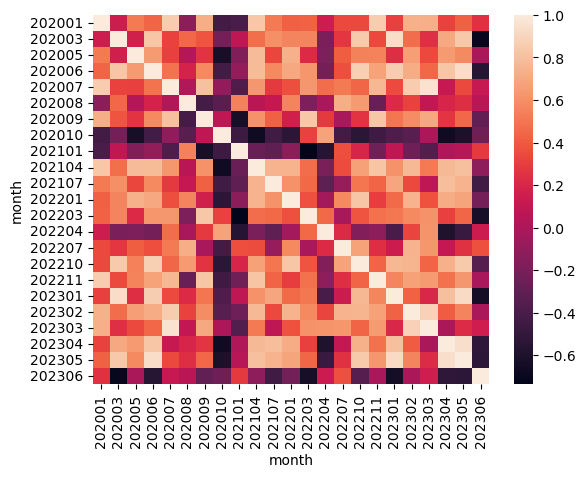

In [53]:
sn.heatmap(
    pd.pivot(
        df_avg_dwells_weekday,
        index="weekday",
        columns="month",
        values="avg_dwells",
    ).corr()
)

## Autocorrelation

In [10]:
user = df_freq_full_home_work.identifier.unique()[0]

In [ ]:
df_freq_full_home_work[df_freq_full_home_work.identifier == user].groupby("month")[
    ["duration_seconds", "bump_count"]
].mean()

duration_seconds  bump_count
month                               
202001       2965.741758    8.324176
202006       2192.447368    7.982456
202009       3119.710145    8.120773
202207       2829.184397    4.226950
202210       2505.117647    4.482353
202211       2587.694737    4.568421
202301       2802.672043    4.494624
202302       2936.503106    4.223602
202303       2689.640244    4.219512
202304       2676.075269    5.731183

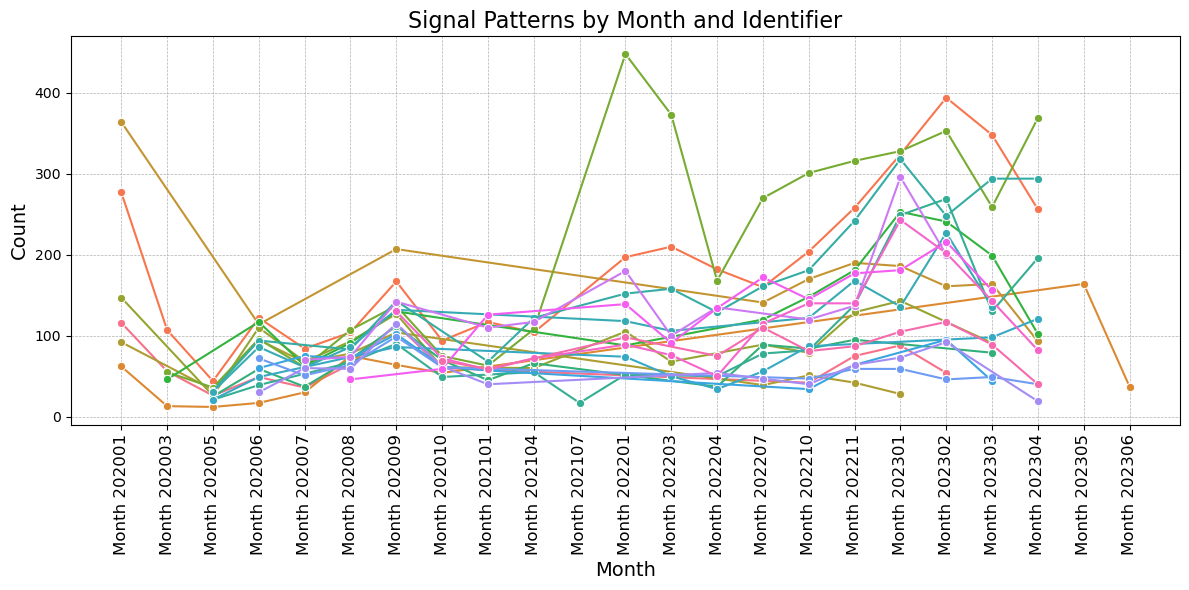

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Group by month and identifier
grouped_data = (
    df_freq_full_home_work.groupby(["month", "identifier"])
    .size()
    .reset_index(name="count")
)

# Create a line plot with hue for identifier
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=grouped_data, x="month", y="count", hue="identifier", marker="o", legend=False
)

# Enhancing the plot
plt.title("Signal Patterns by Month and Identifier", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(
    ticks=grouped_data["month"].unique(),
    labels=[f"Month {m}" for m in grouped_data["month"].unique()],
    fontsize=12,
)
# plt.legend(title="Identifier", fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.xticks(rotation="vertical")
plt.tight_layout()
plt.show()

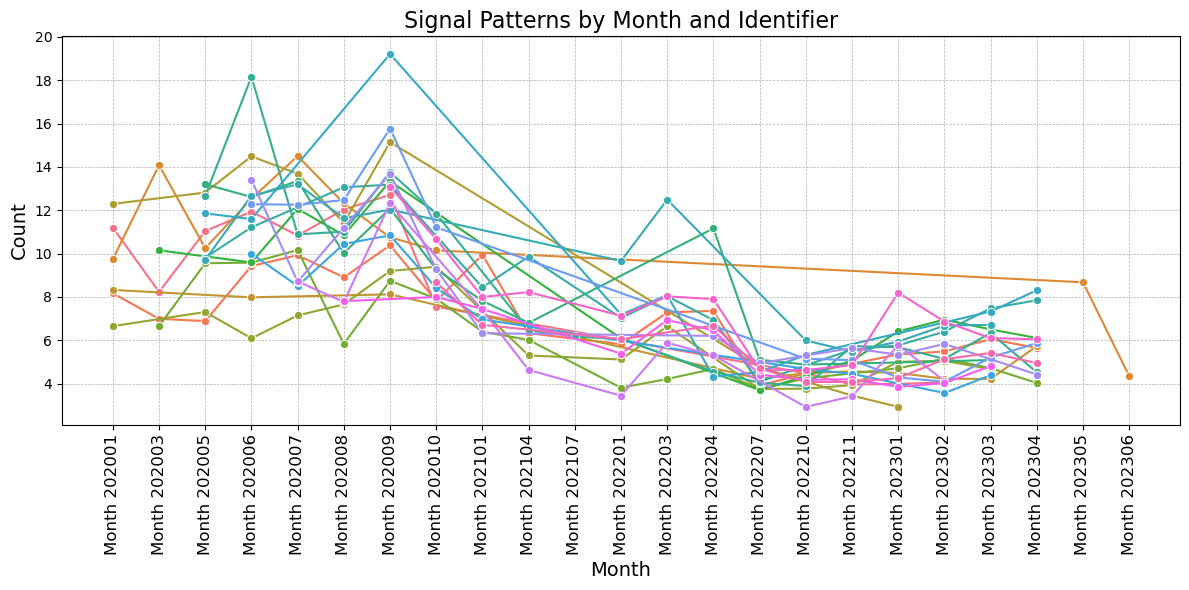

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Group by month and identifier
grouped_data = (
    df_freq_full_home_work.groupby(["month", "identifier"])["bump_count"]
    .mean()
    .reset_index()
)

# Create a line plot with hue for identifier
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=grouped_data,
    x="month",
    y="bump_count",
    hue="identifier",
    marker="o",
    legend=False,
)

# Enhancing the plot
plt.title("Signal Patterns by Month and Identifier", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(
    ticks=grouped_data["month"].unique(),
    labels=[f"Month {m}" for m in grouped_data["month"].unique()],
    fontsize=12,
)
# plt.legend(title="Identifier", fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.xticks(rotation="vertical")
plt.tight_layout()
plt.show()

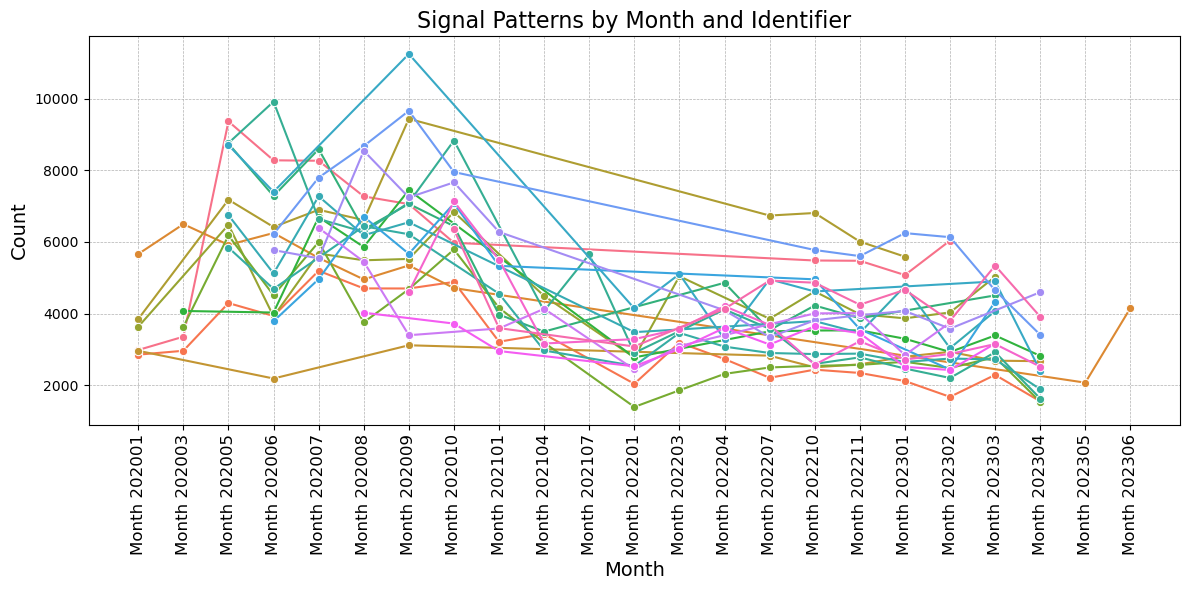

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn


# Group by month and identifier
grouped_data = (
    df_freq_full_home_work.groupby(["month", "identifier"])["duration_seconds"]
    .mean()
    .reset_index()
)

# Create a line plot with hue for identifier
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=grouped_data,
    x="month",
    y="duration_seconds",
    hue="identifier",
    marker="o",
    legend=False,
)

# Enhancing the plot
plt.title("Signal Patterns by Month and Identifier", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(
    ticks=grouped_data["month"].unique(),
    labels=[f"Month {m}" for m in grouped_data["month"].unique()],
    fontsize=12,
)
# plt.legend(title="Identifier", fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.xticks(rotation="vertical")
plt.tight_layout()
plt.show()

In [54]:
df_freq_full_home_work.groupby('month')['identifier'].nunique()

month
202001     6
202003     5
202005    11
202006    16
202007    14
202008    16
202009    18
202010    13
202101    10
202104     8
202107     1
202201    12
202203     9
202204    11
202207    14
202210    19
202211    18
202301    16
202302    16
202303    15
202304    11
202305     1
202306     1
Name: identifier, dtype: int64

In [ ]:
month_week_user_signals = pd.pivot_table(df_freq_full_home_work
               , columns = "flag_type_loc_new"
               , index= ['month','weekday','identifier']
              , values='bump_count'
               ,aggfunc='count'
).fillna(0).reset_index()

In [47]:
# Group by month and identifier
grouped_data = (
    
    month_week_user_signals
    .groupby(["month", "weekday"])
        [['home','other','work']].sum().reset_index()
)

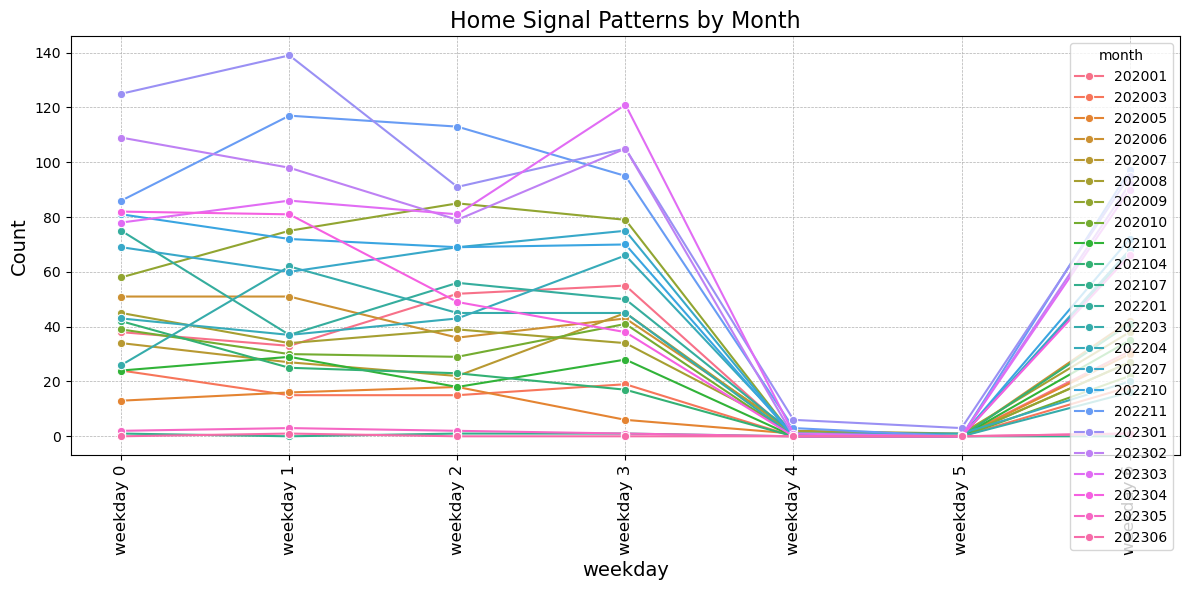

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns




# Create a line plot with hue for identifier
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=grouped_data,
    x="weekday",
    y="work",
    hue="month",
    marker="o",
)

# Enhancing the plot
plt.title("Home Signal Patterns by Month", fontsize=16)
plt.xlabel("weekday", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(
    ticks=grouped_data["weekday"].unique(),
    labels=[f"weekday {m}" for m in grouped_data["weekday"].unique()],
    fontsize=12,
)
# plt.legend(title="Identifier", fontsize=12)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.xticks(rotation="vertical")
plt.tight_layout()
plt.show()

In [51]:
grouped_data

flag_type_loc_new   month  weekday  home  other  work
0                  202001        0  49.0   76.0  38.0
1                  202001        1  34.0   65.0  33.0
2                  202001        2  56.0  122.0  52.0
3                  202001        3  31.0   77.0  55.0
4                  202001        4  66.0   91.0   0.0
..                    ...      ...   ...    ...   ...
156                202306        2   0.0    6.0   0.0
157                202306        3   0.0    5.0   0.0
158                202306        4   3.0    5.0   0.0
159                202306        5   3.0    2.0   0.0
160                202306        6   1.0    4.0   1.0

[161 rows x 5 columns]

<Axes: xlabel='month', ylabel='month'>

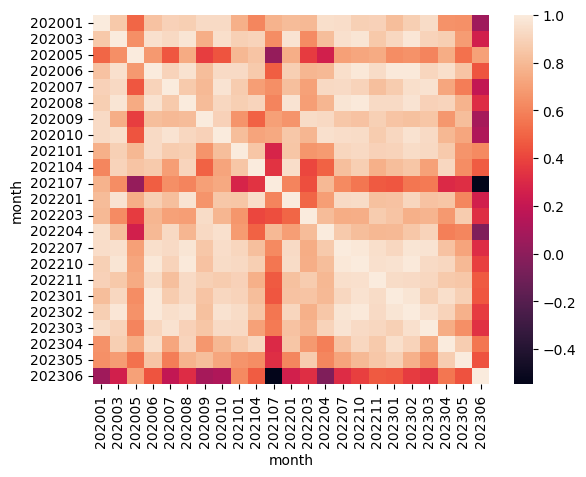

In [56]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.heatmap(
    pd.pivot(
        grouped_data,
        index="weekday",
        columns="month",
        values="work",
    ).corr()
)

In [72]:
corrt_work = pd.pivot(
        grouped_data,
        index="weekday",
        columns="month",
        values="work",
    ).corr()
(corrt_work>0.8).sum()

month
202001    15
202003    17
202005     2
202006    18
202007    15
202008    17
202009    14
202010    16
202101    15
202104    12
202107     1
202201    16
202203     6
202204    11
202207    18
202210    18
202211    18
202301    19
202302    18
202303    16
202304    13
202305     7
202306     1
dtype: int64

<Axes: xlabel='month', ylabel='month'>

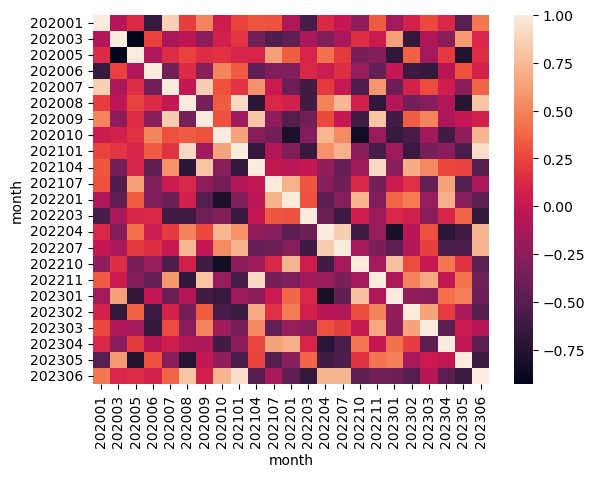

In [74]:
import matplotlib.pyplot as plt
import seaborn as sn

    
corrt_home = pd.pivot(
        grouped_data,
        index="weekday",
        columns="month",
        values="home",
    ).corr()
sn.heatmap(corrt_home)


<Axes: xlabel='month', ylabel='month'>

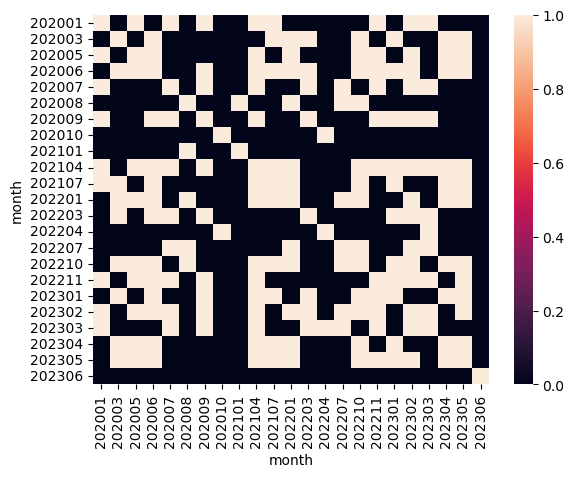

In [77]:
#all signals
corrt = pd.pivot(
        df_avg_dwells_weekday,
        index="weekday",
        columns="month",
        values="avg_dwells",
    ).corr()
sn.heatmap(
    corrt>0.5
)

### By hour

In [87]:
df_freq_full_home_work["hours_in_interval"] = df_freq_full_home_work.apply(
    lambda row: pd.date_range(
        start=row["start_date_time"].floor("h"),
        end=row["end_date_time"].ceil("h") - pd.Timedelta(hours=1),
        freq="h",
    ).tolist(),
    axis=1,
)
df_hours = df_freq_full_home_work.explode("hours_in_interval")
df_hours["hour"] = df_hours["hours_in_interval"].dt.hour

In [88]:
df_hours.head()

identifier identifier_type           timestamp  \
0  0efd806b-dfad-456e-8ab0-27eefa5f2cc3            GAID 2020-01-05 17:29:52   
0  0efd806b-dfad-456e-8ab0-27eefa5f2cc3            GAID 2020-01-05 17:29:52   
0  0efd806b-dfad-456e-8ab0-27eefa5f2cc3            GAID 2020-01-05 17:29:52   
1  0efd806b-dfad-456e-8ab0-27eefa5f2cc3            GAID 2020-01-29 07:01:23   
2  0efd806b-dfad-456e-8ab0-27eefa5f2cc3            GAID 2020-01-18 03:17:34   

      local_date_time  province classification  duration_seconds  \
0 2020-01-05 19:29:52  HaMerkaz     AREA_DWELL            5928.0   
0 2020-01-05 19:29:52  HaMerkaz     AREA_DWELL            5928.0   
0 2020-01-05 19:29:52  HaMerkaz     AREA_DWELL            5928.0   
1 2020-01-29 09:01:23  HaMerkaz     AREA_DWELL             308.0   
2 2020-01-18 05:17:34  HaMerkaz     AREA_DWELL            2361.0   

   centroid_latitude  centroid_longitude  bump_count  ... flag_work_geohash  \
0          32.318970           34.864802          17  ...             False   
0          32.318970           34.864802          17  ...             False   
0          32.318970           34.864802          17  ...             False   
1          32.318679           34.864854           9  ...             False   
2          32.319009           34.864648           5  ...             False   

                                       geometry_home distance_home  \
0  POLYGON ((34.8651123046875 32.31903076171875, ...     29.947893   
0  POLYGON ((34.8651123046875 32.31903076171875, ...     29.947893   
0  POLYGON ((34.8651123046875 32.31903076171875, ...     29.947893   
1  POLYGON ((34.8651123046875 32.31903076171875, ...     45.961084   
2  POLYGON ((34.8651123046875 32.31903076171875, ...     43.795434   

   flag_home_geohash  flag_type_loc_new                   geometry day  \
0               True               home   POINT (34.8648 32.31897)   5   
0               True               home   POINT (34.8648 32.31897)   5   
0               True               home   POINT (34.8648 32.31897)   5   
1               True               home  POINT (34.86485 32.31868)  29   
2               True               home  POINT (34.86465 32.31901)  18   

  weekday   hours_in_interval  hour  
0       6 2020-01-05 19:00:00    19  
0       6 2020-01-05 20:00:00    20  
0       6 2020-01-05 21:00:00    21  
1       2 2020-01-29 09:00:00     9  
2       5 2020-01-18 05:00:00     5  

[5 rows x 36 columns]

<Axes: xlabel='month', ylabel='month'>

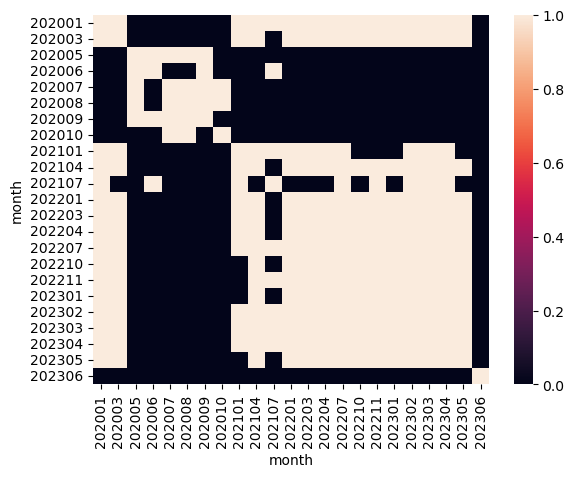

In [91]:
corrt = pd.pivot_table(
        df_hours,
        index="hour",
        columns="month",
        values="day",
        aggfunc='count'
    ).corr()
sn.heatmap(
    corrt>0.6
)

In [79]:
grouped_data = (
    
    month_day_user_signals
    .groupby(["month", "day"])
        [['home','other','work']].sum().reset_index()
)

In [32]:
import pandas as pd


# Convert 'month' to datetime and subtract one month
df_avg_dwells_weekday['month_lag'] = pd.to_datetime(df_avg_dwells_weekday['month'], format='%Y%m') \
    .apply(lambda x: x - pd.DateOffset(months=1)) \
    .dt.strftime('%Y%m')

# Display the result
print(df_avg_dwells_weekday)


      month  weekday  avg_dwells month_lag
0    202001        0   27.166667    201912
1    202001        1   22.000000    201912
2    202001        2   38.333333    201912
3    202001        3   27.166667    201912
4    202001        4   26.166667    201912
..      ...      ...         ...       ...
156  202306        2    6.000000    202305
157  202306        3    5.000000    202305
158  202306        4    8.000000    202305
159  202306        5    5.000000    202305
160  202306        6    6.000000    202305

[161 rows x 4 columns]


In [ ]:
df_avg_dwells_weekday.merge(df_avg_dwells_weekday,on = )

<Figure size 1200x600 with 0 Axes>

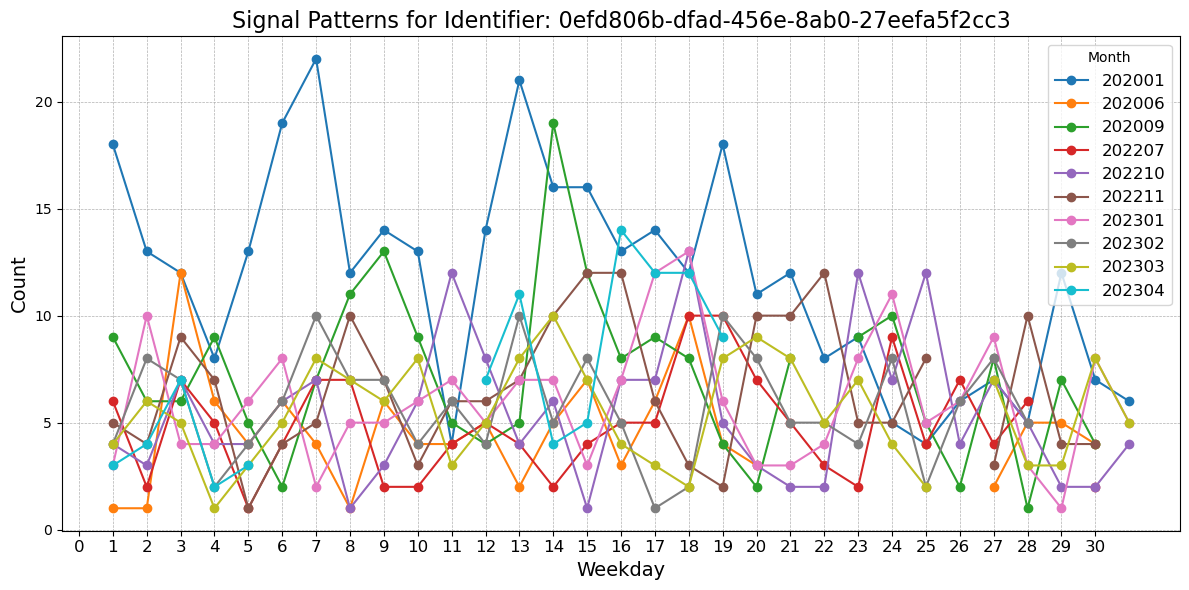

<Figure size 1200x600 with 0 Axes>

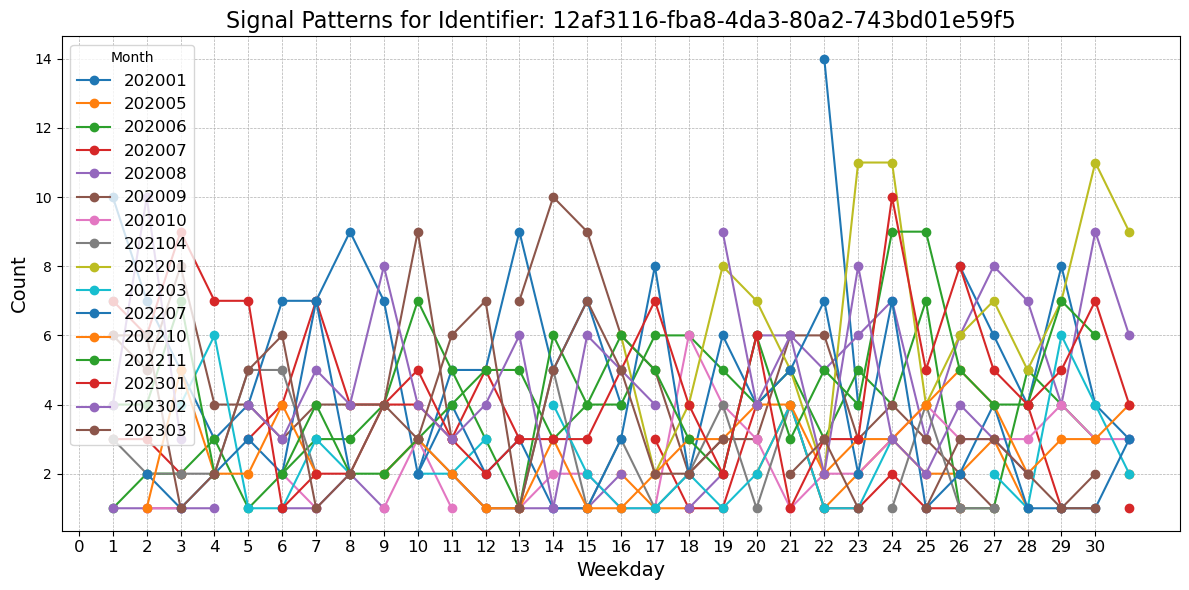

<Figure size 1200x600 with 0 Axes>

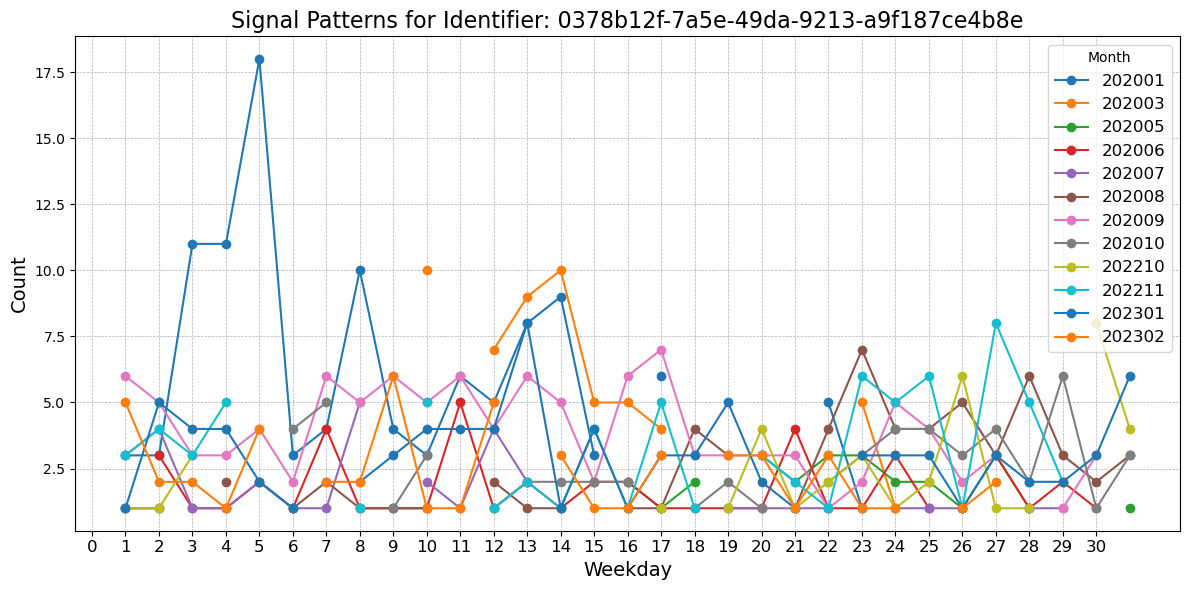

<Figure size 1200x600 with 0 Axes>

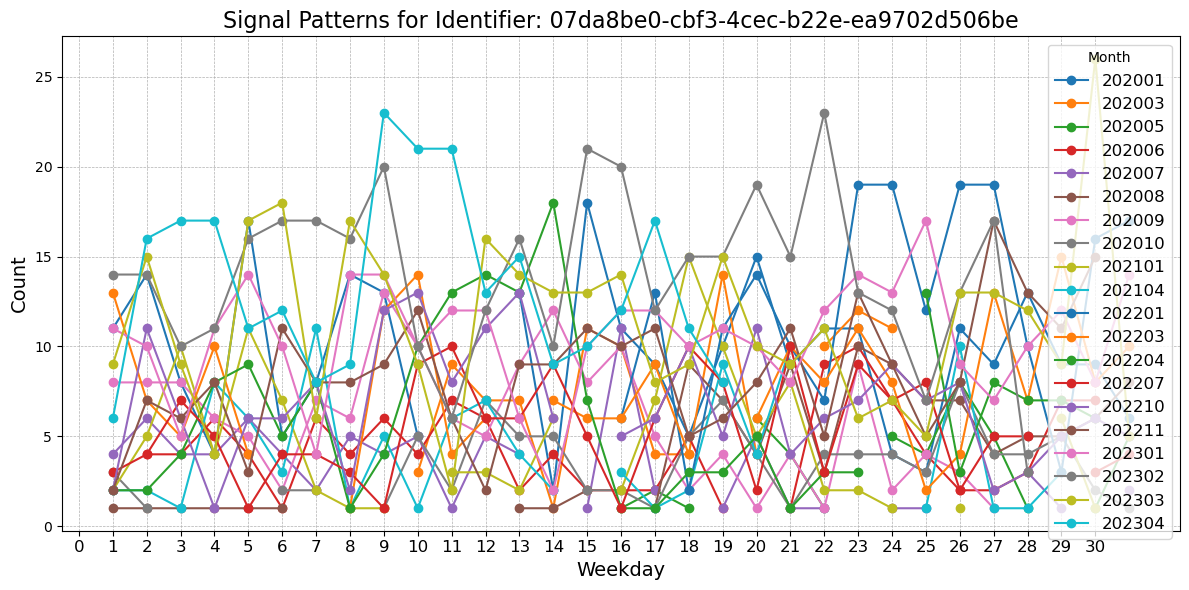

<Figure size 1200x600 with 0 Axes>

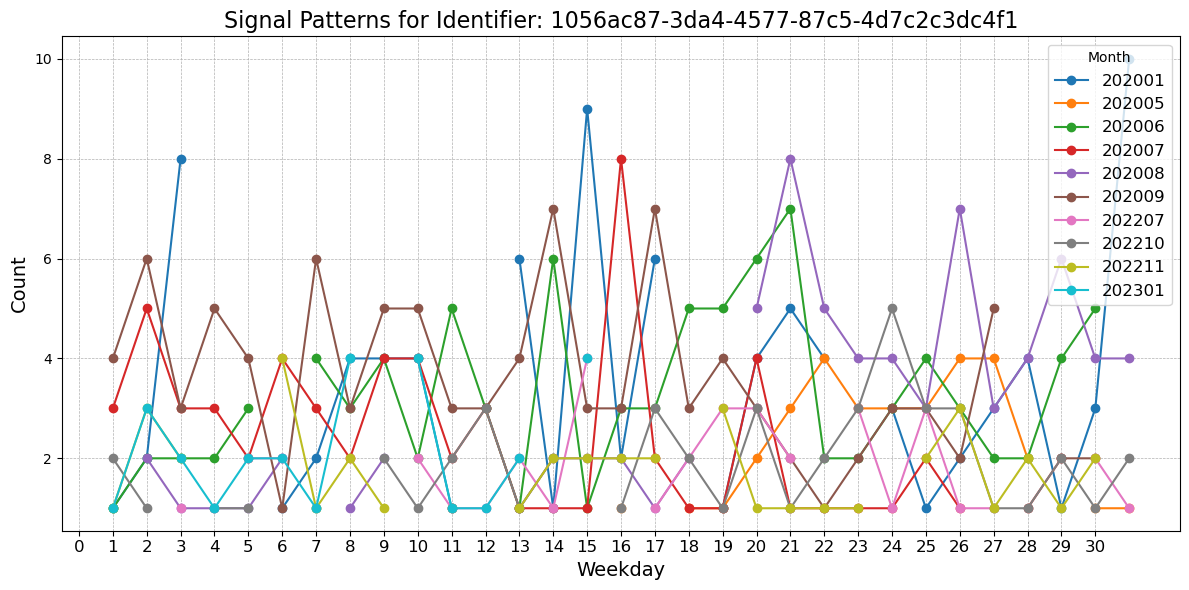

<Figure size 1200x600 with 0 Axes>

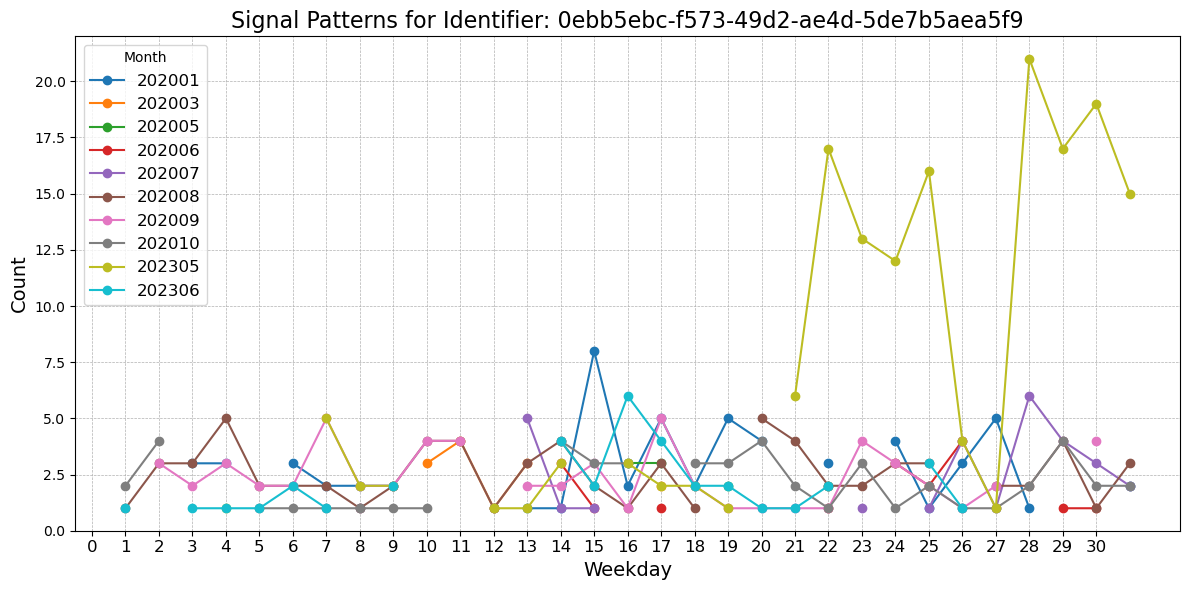

<Figure size 1200x600 with 0 Axes>

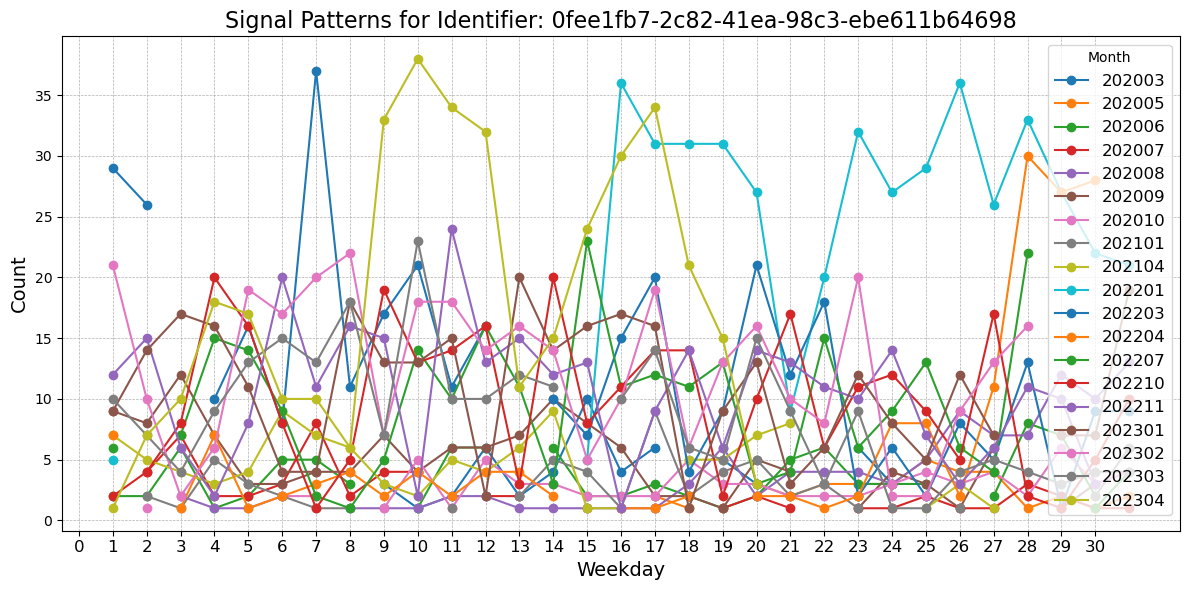

<Figure size 1200x600 with 0 Axes>

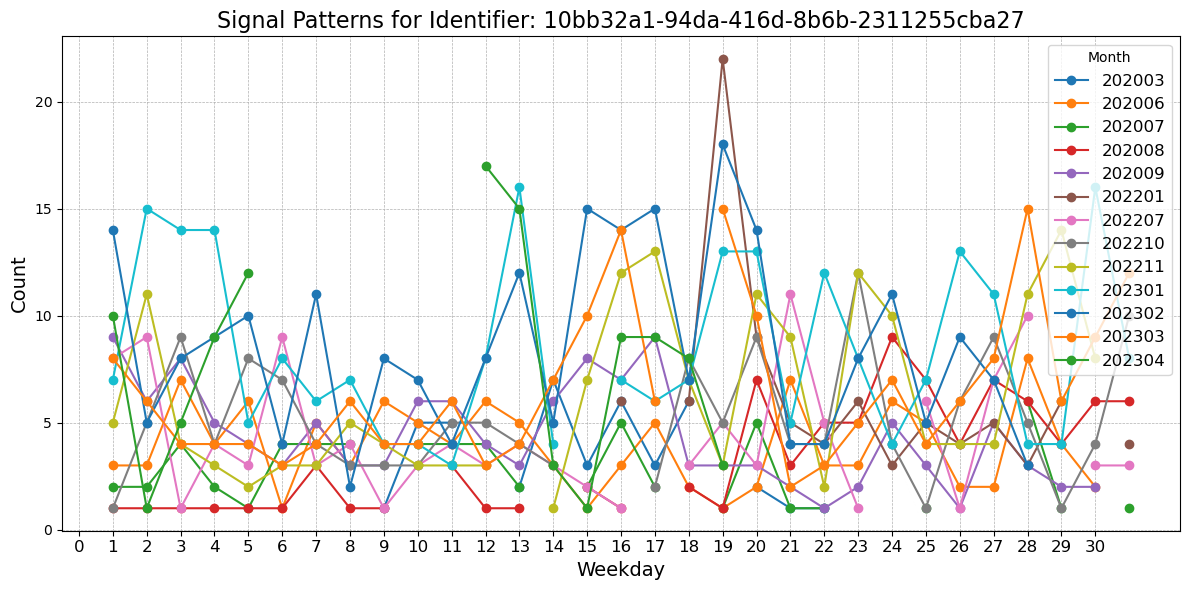

<Figure size 1200x600 with 0 Axes>

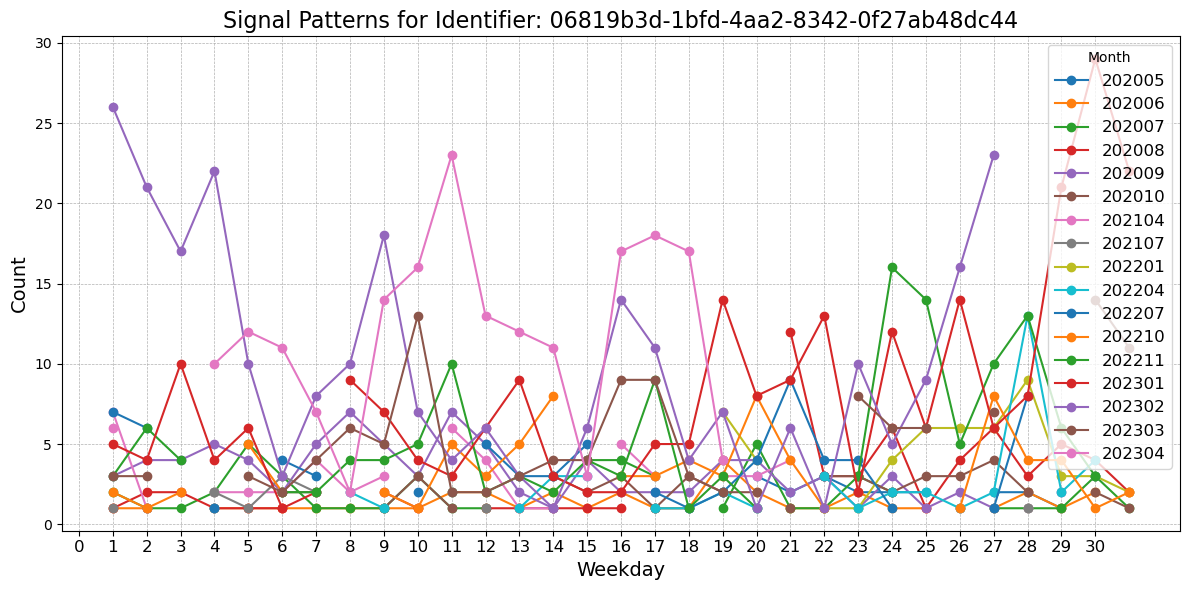

<Figure size 1200x600 with 0 Axes>

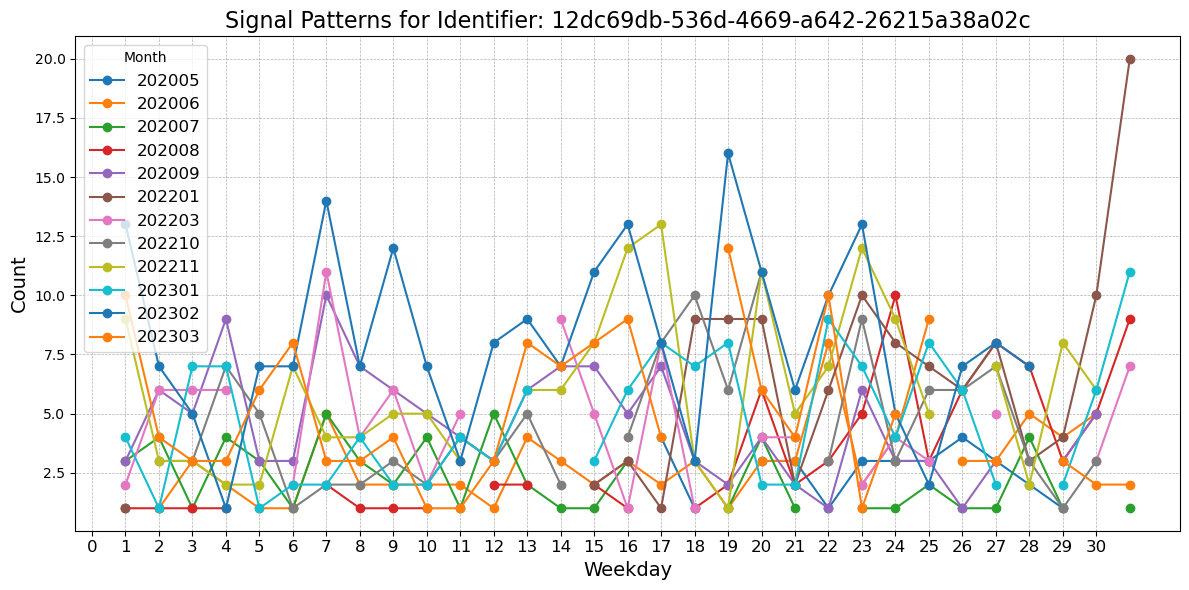

<Figure size 1200x600 with 0 Axes>

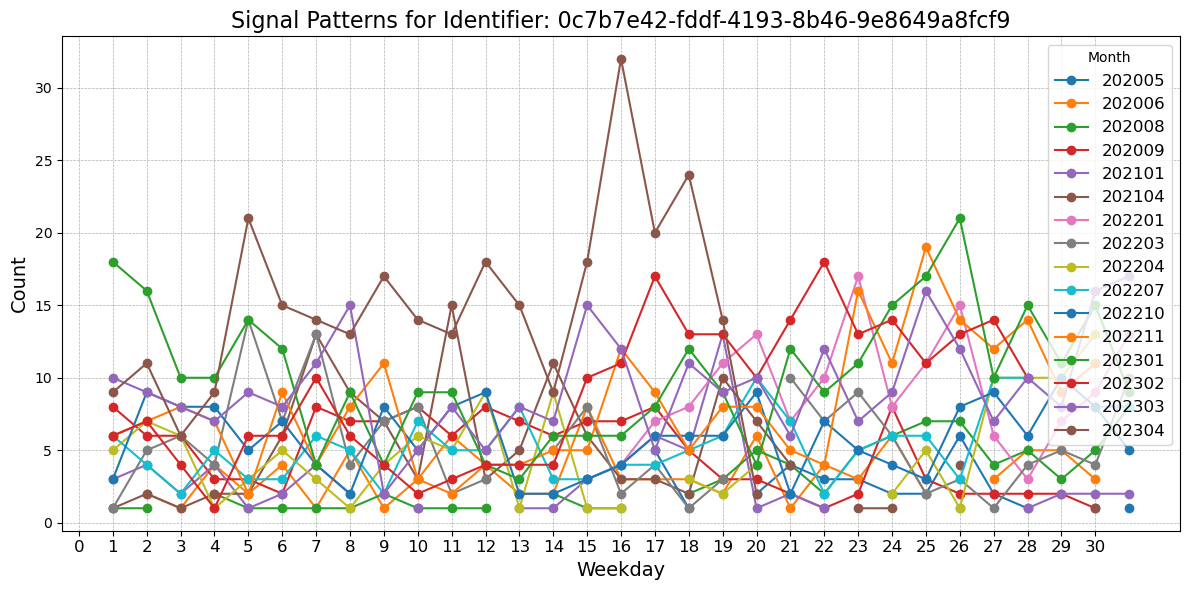

<Figure size 1200x600 with 0 Axes>

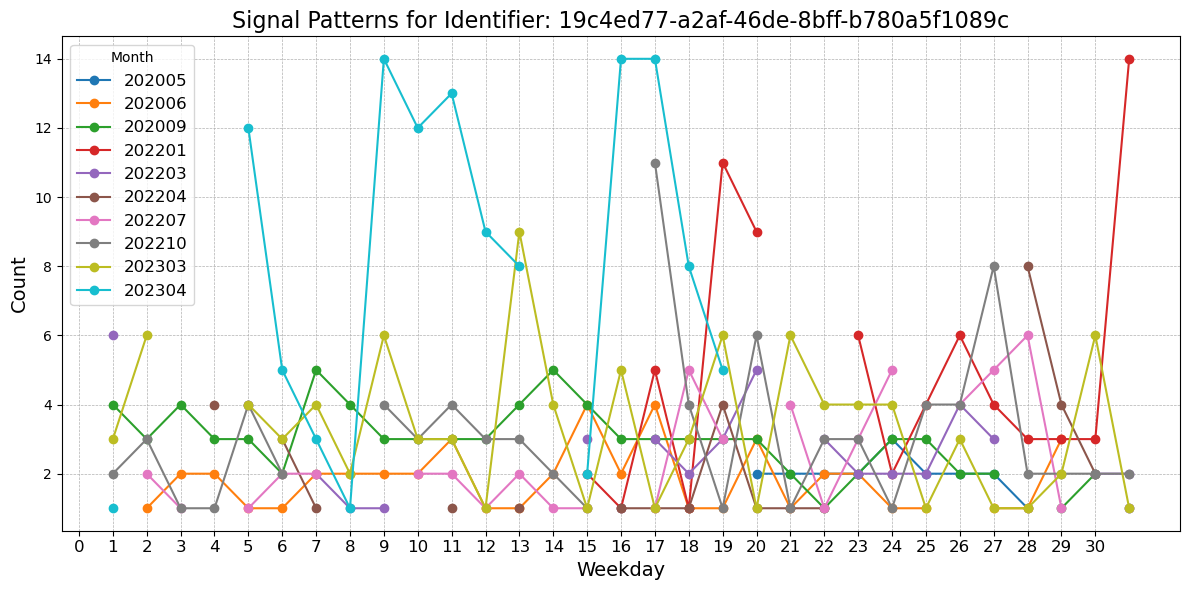

<Figure size 1200x600 with 0 Axes>

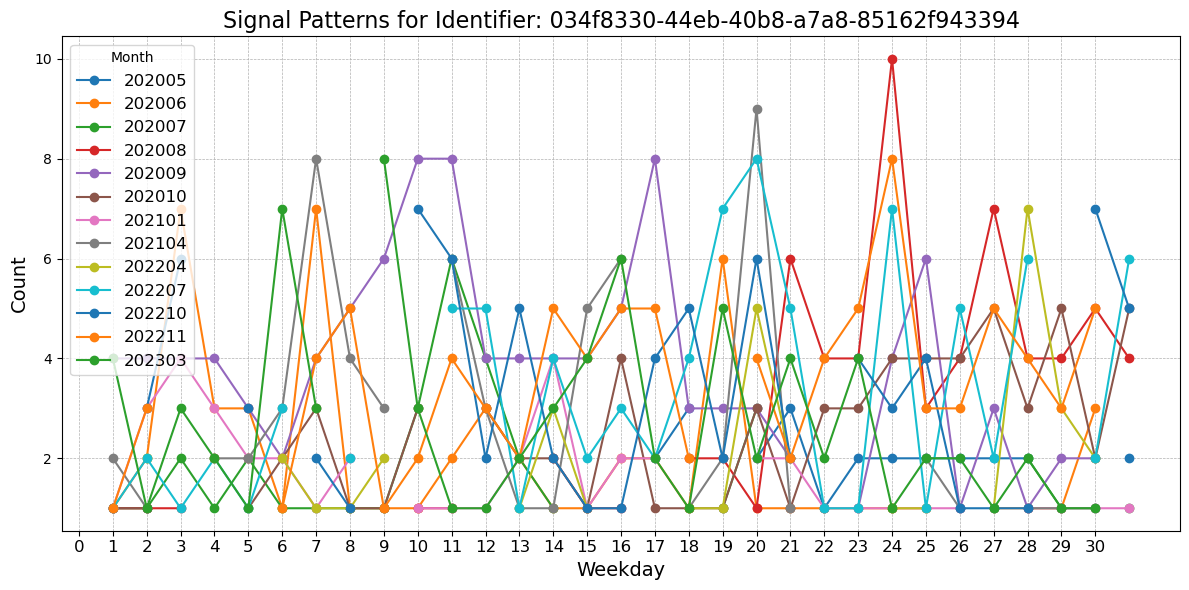

<Figure size 1200x600 with 0 Axes>

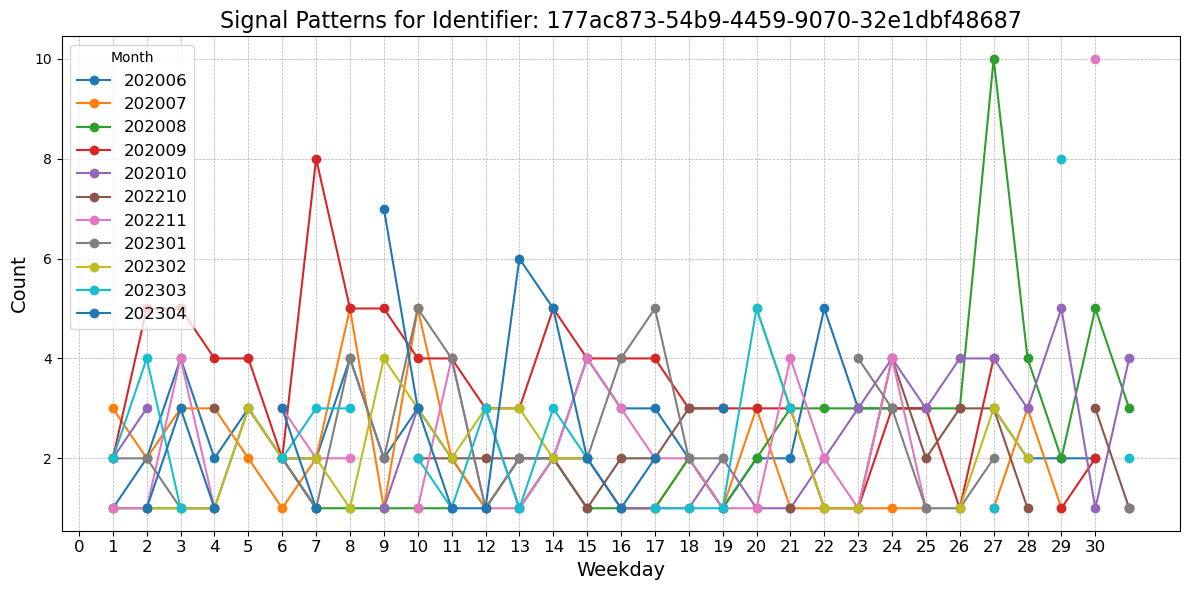

<Figure size 1200x600 with 0 Axes>

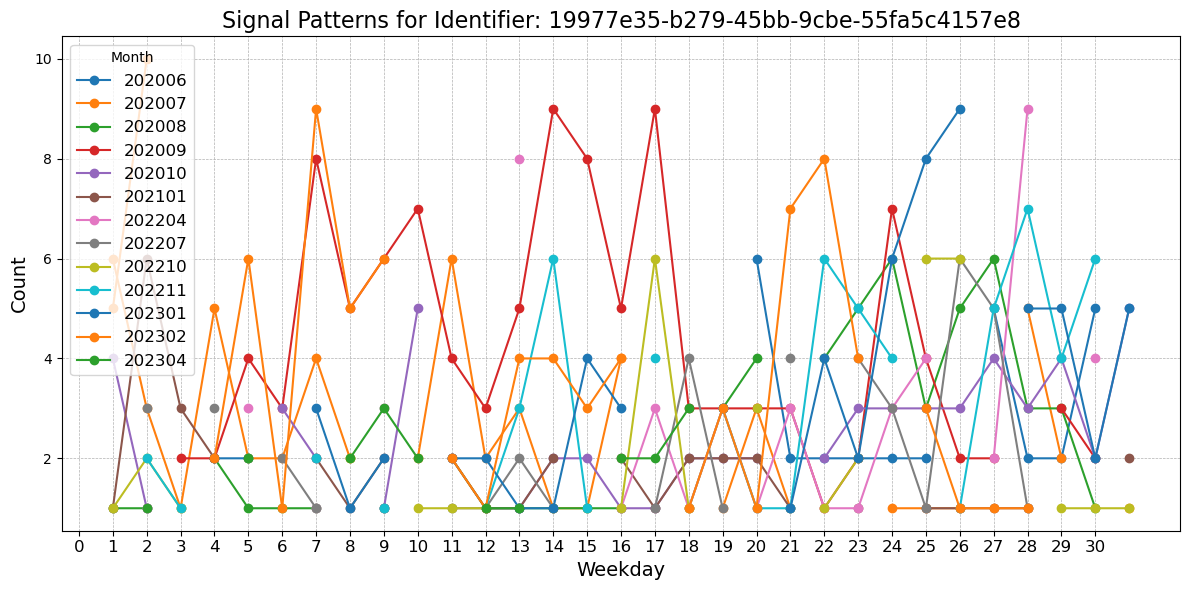

<Figure size 1200x600 with 0 Axes>

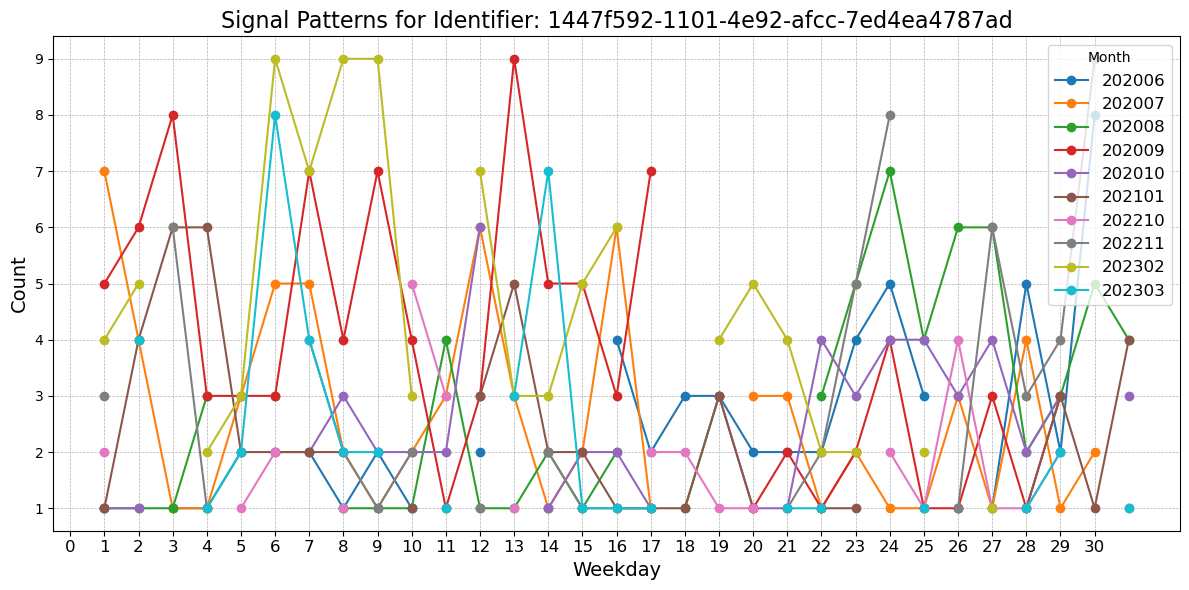

<Figure size 1200x600 with 0 Axes>

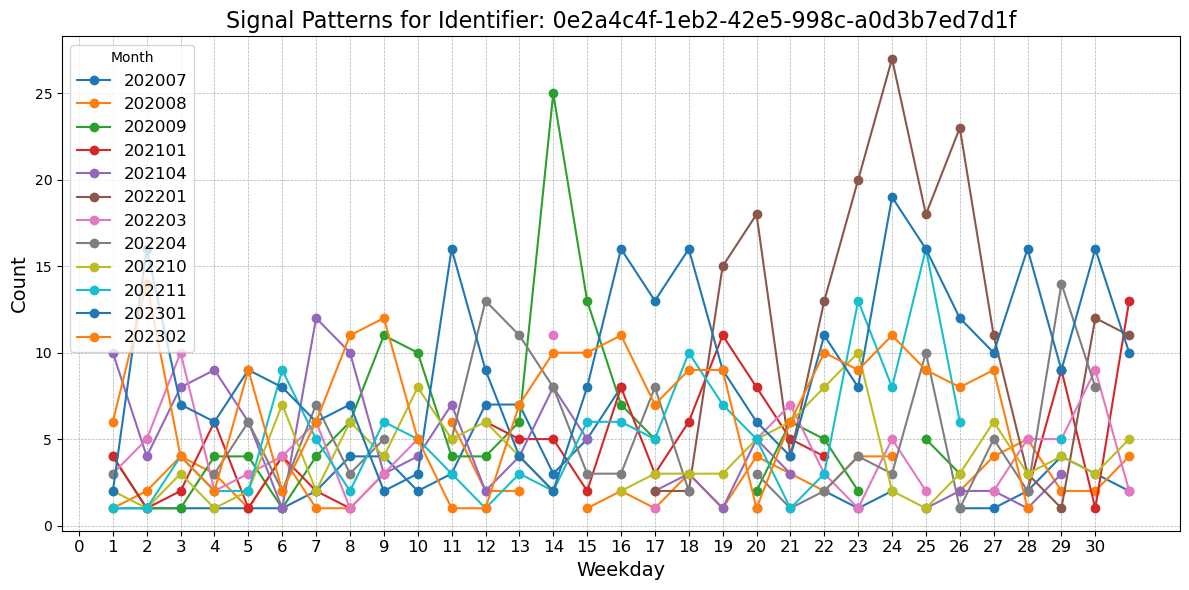

<Figure size 1200x600 with 0 Axes>

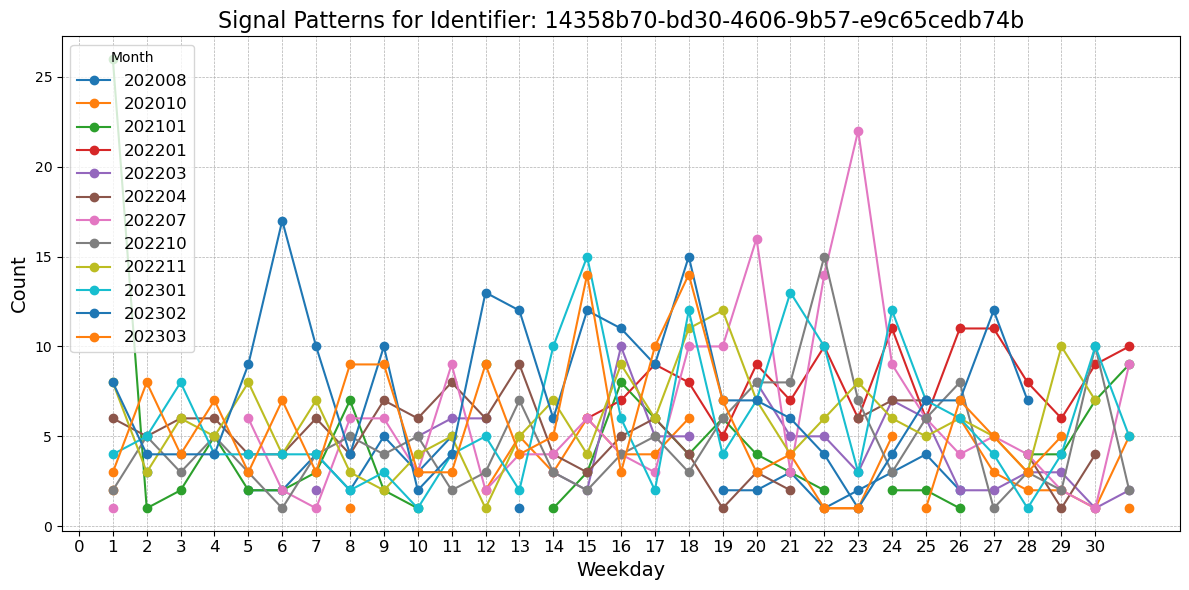

<Figure size 1200x600 with 0 Axes>

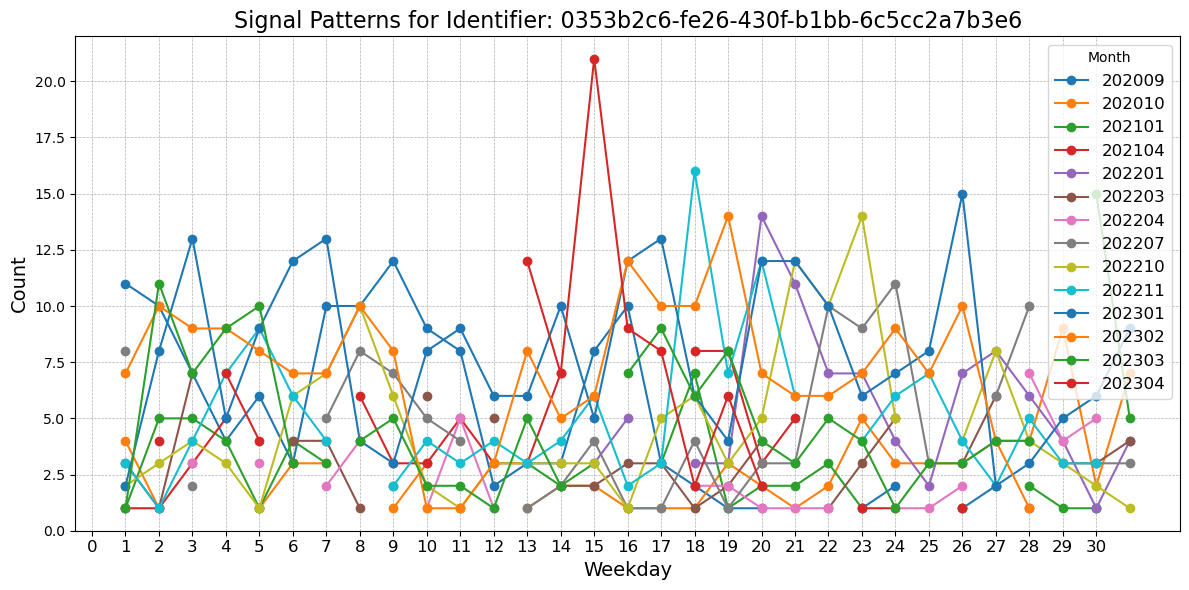

<Figure size 1200x600 with 0 Axes>

KeyboardInterrupt: 

In [ ]:
for user in df_freq_full_home_work.identifier.unique():
    grouped_data = (
        df_freq_full_home_work[df_freq_full_home_work.identifier == user]
        .groupby(["month", "day"])
        .size()
    )

    # Plot
    plt.figure(figsize=(12, 6))
    grouped_data.unstack(level=0).plot(kind="line", marker="o", figsize=(12, 6))
    plt.title(f"Signal Patterns for Identifier: {user}", fontsize=16)
    plt.xlabel("Day", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(ticks=range(1, 32), fontsize=12)
    plt.legend(title="Month", fontsize=12)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

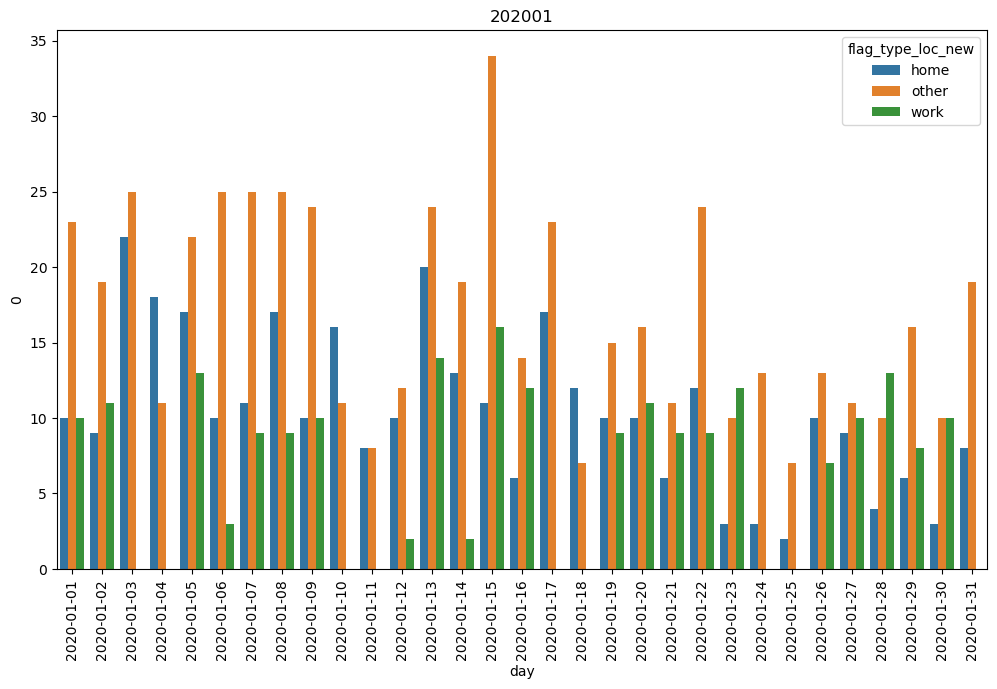

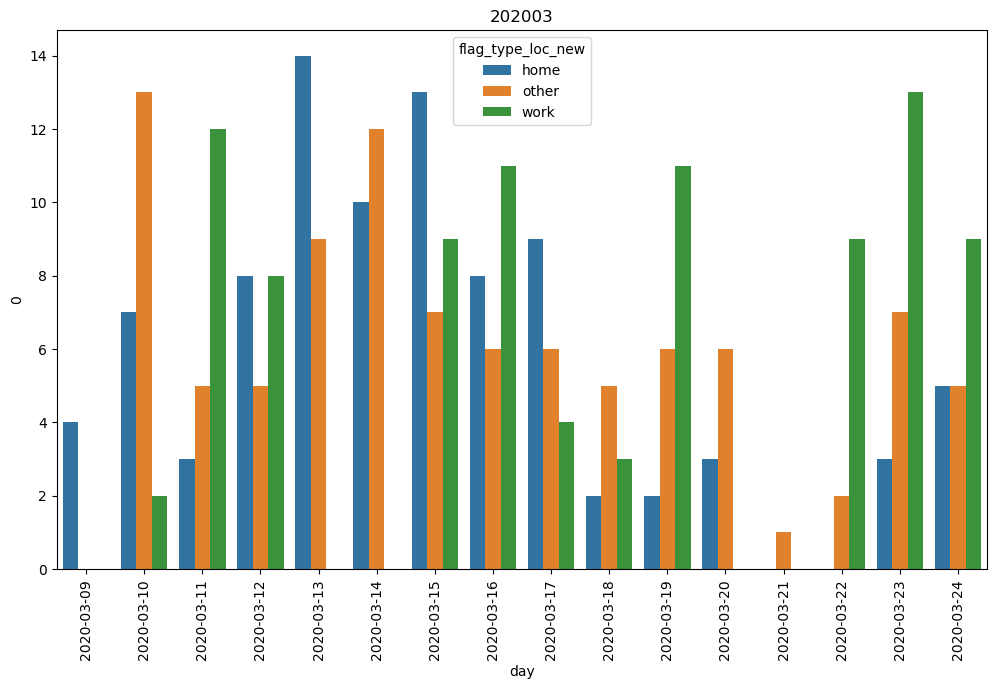

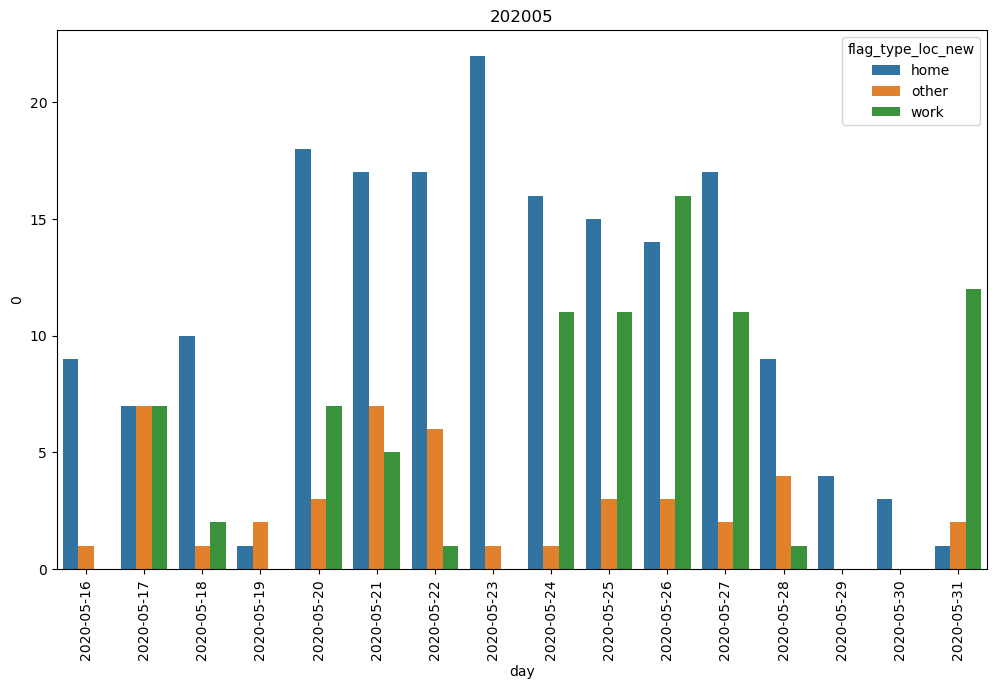

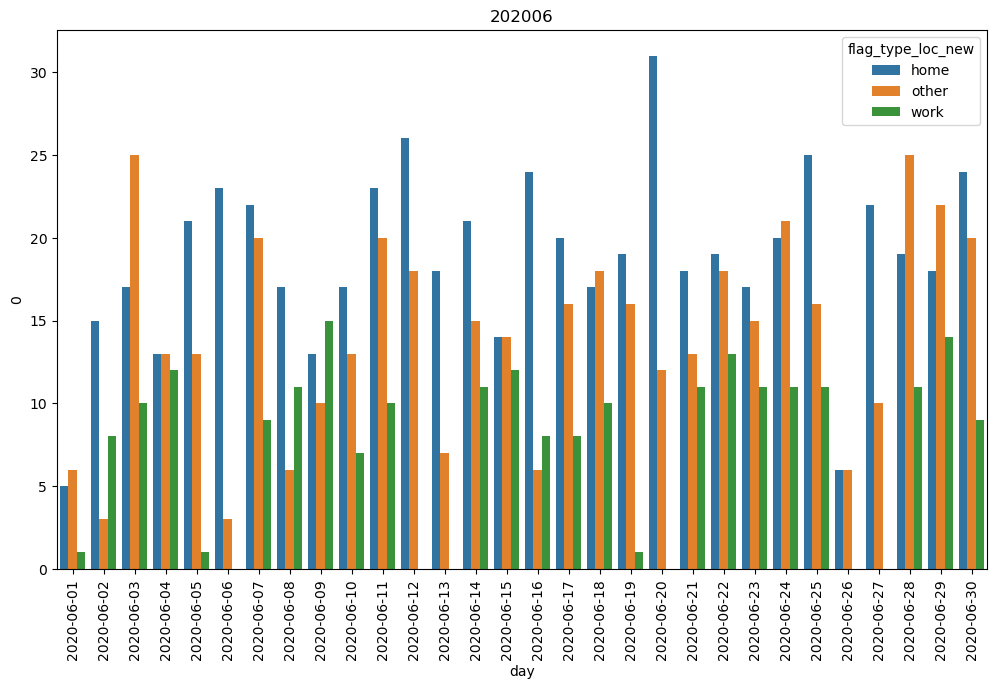

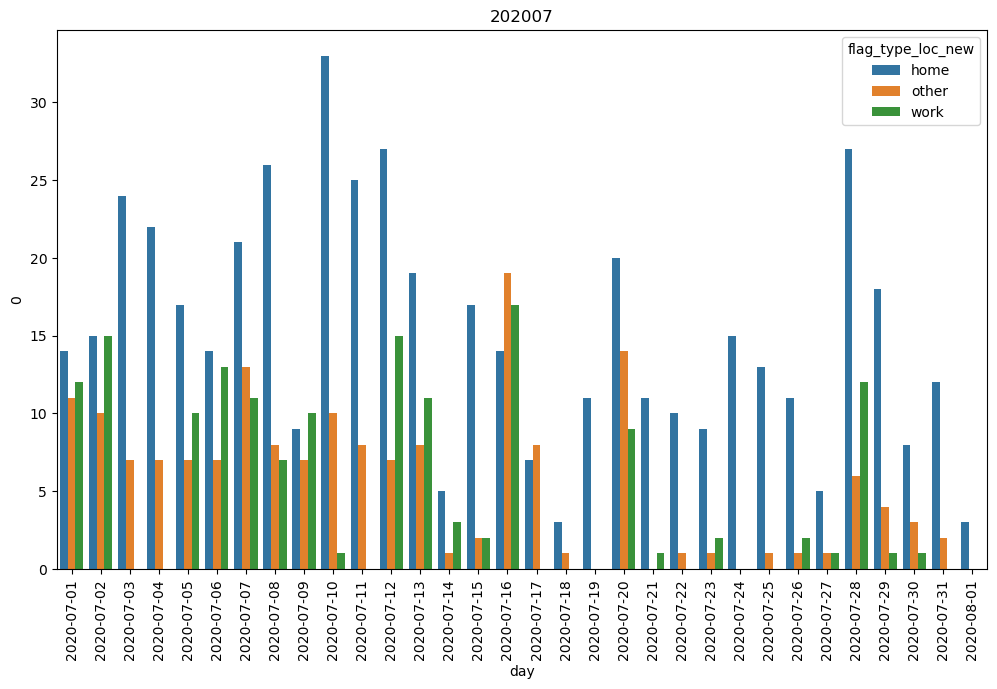

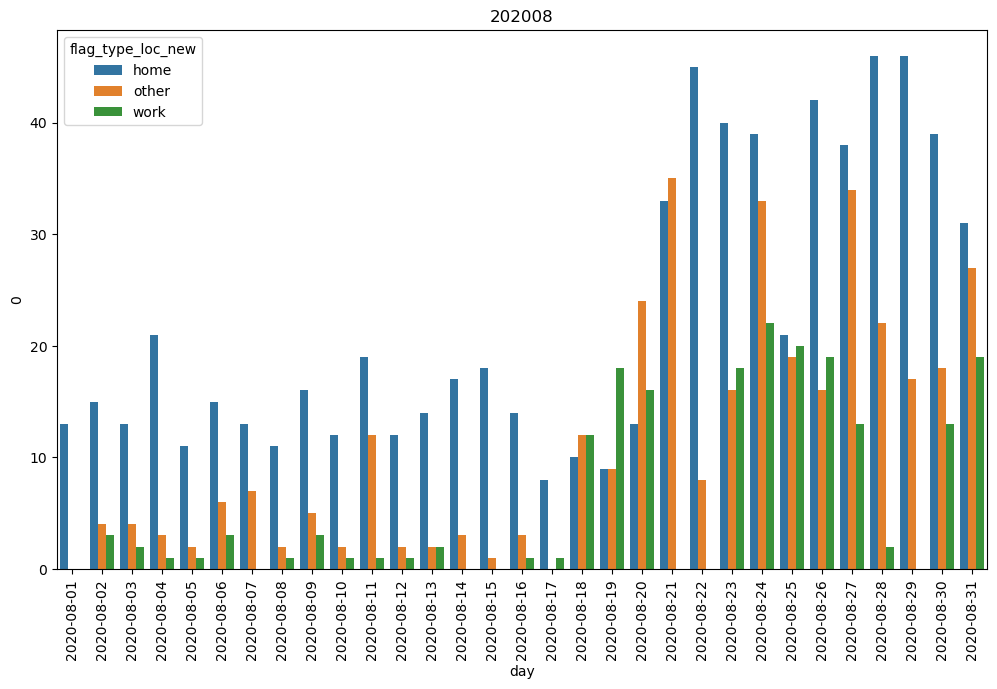

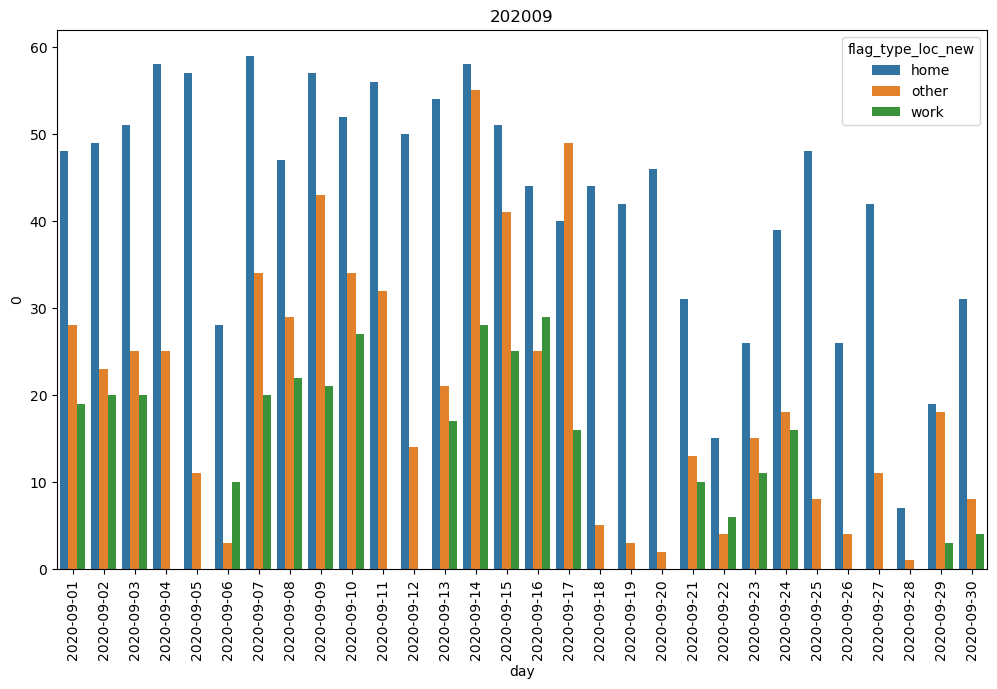

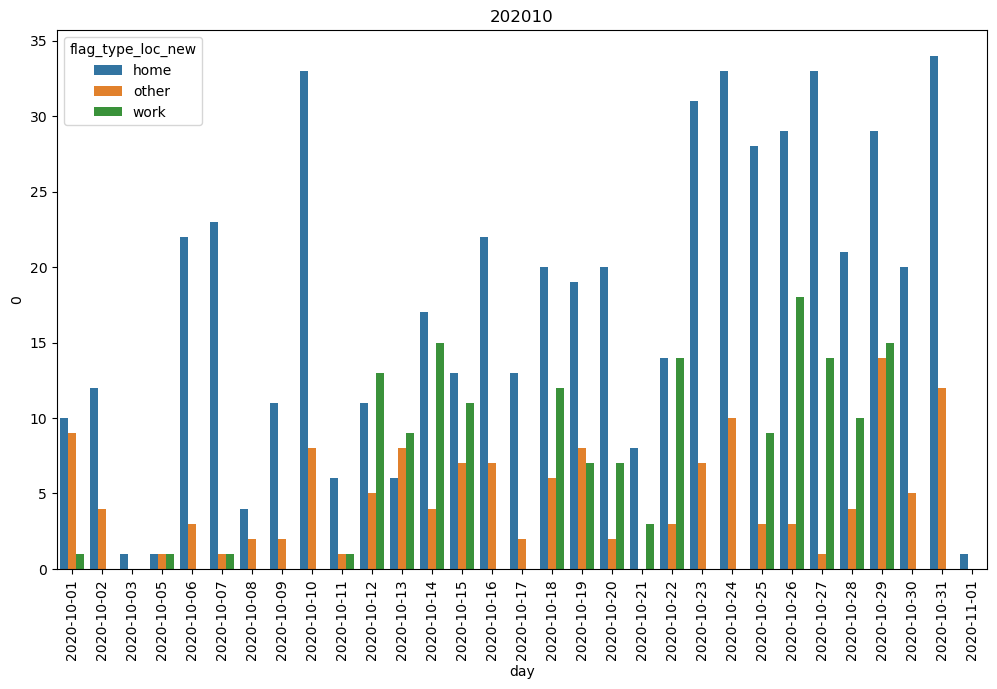

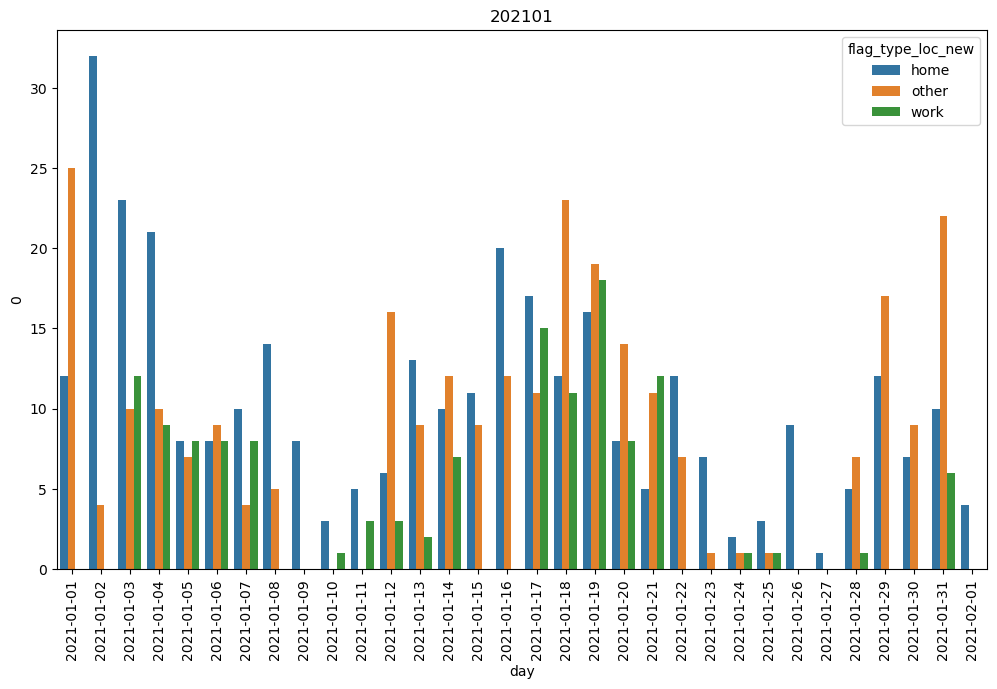

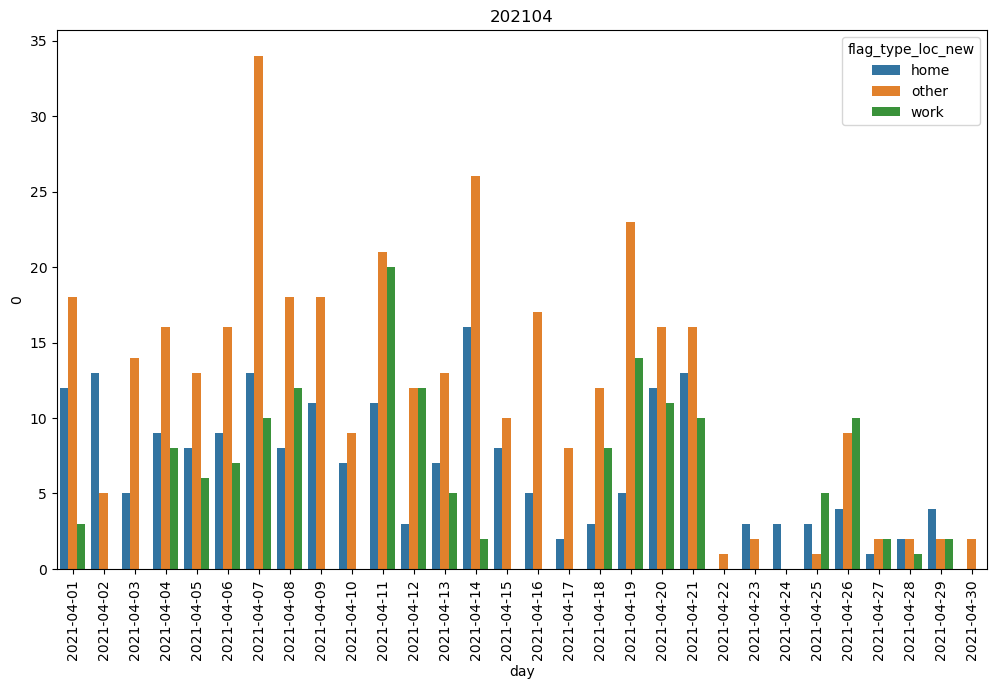

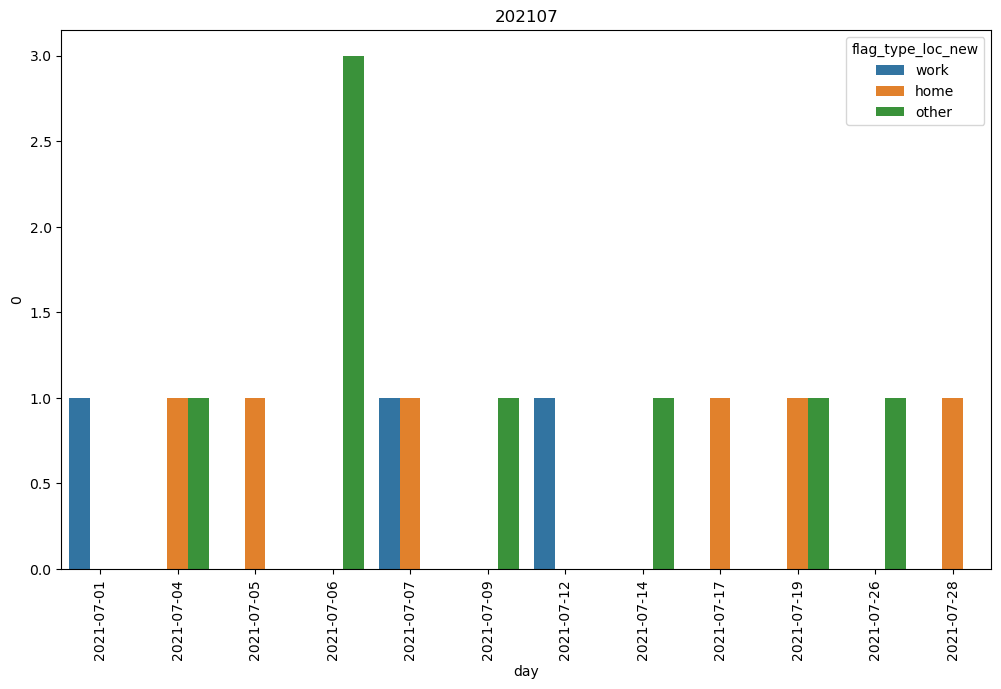

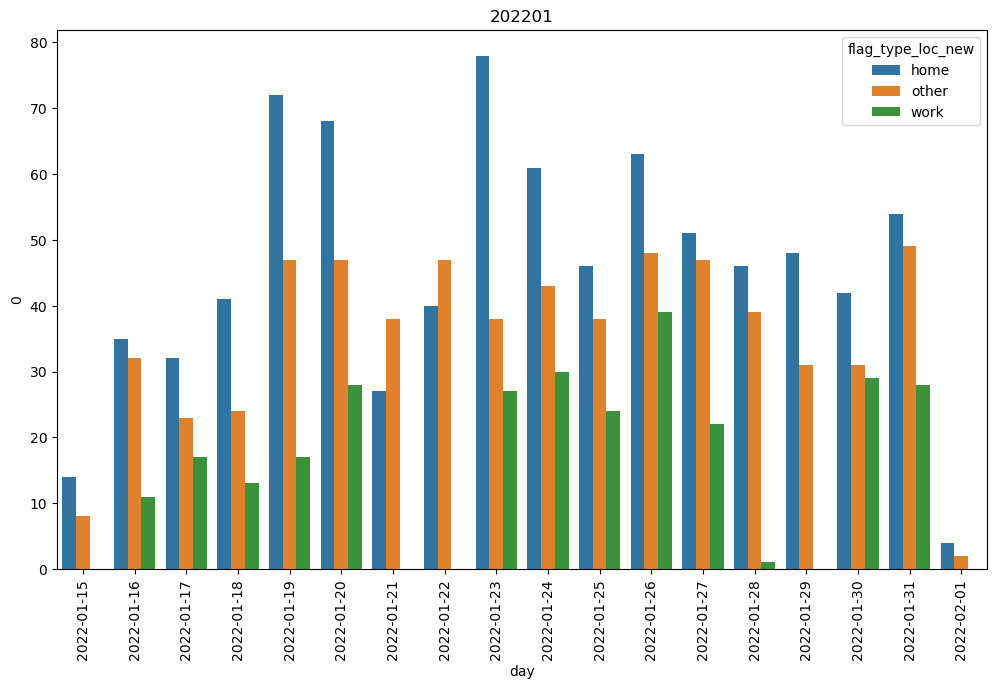

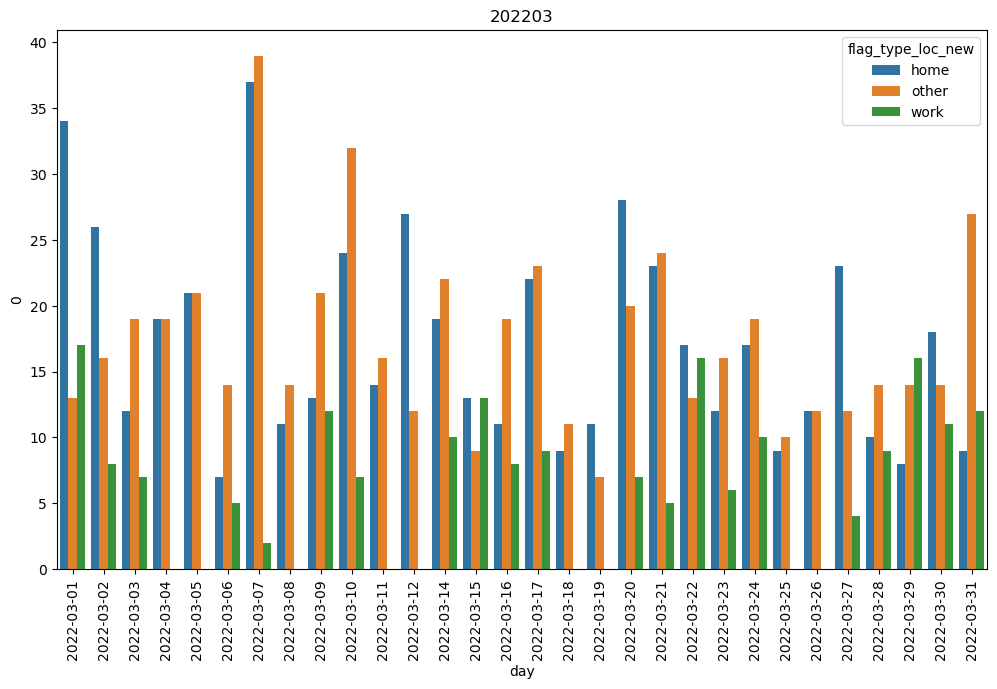

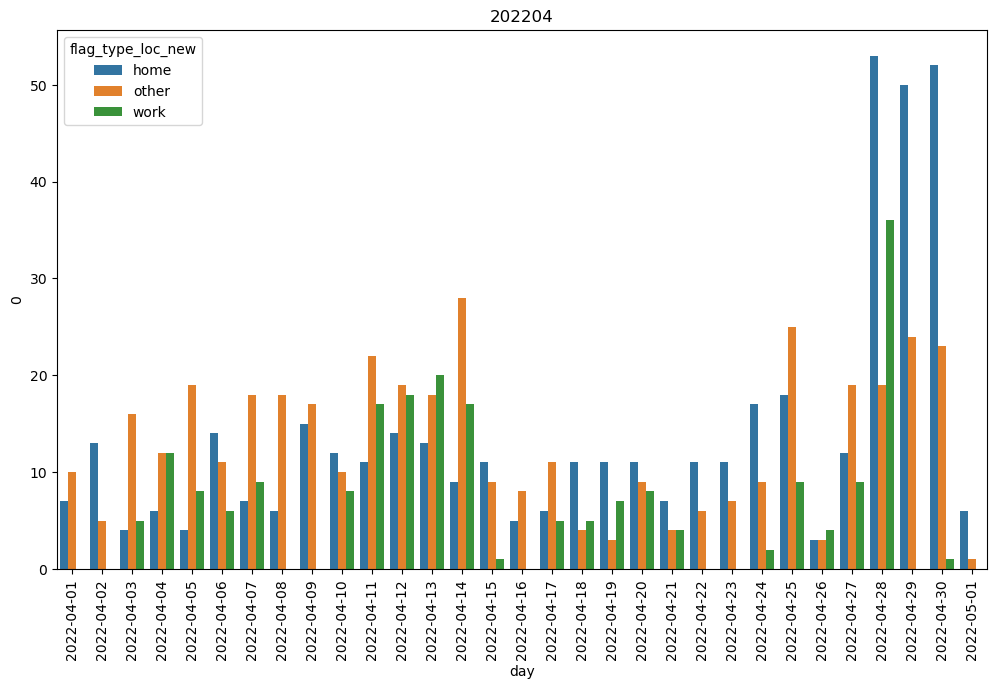

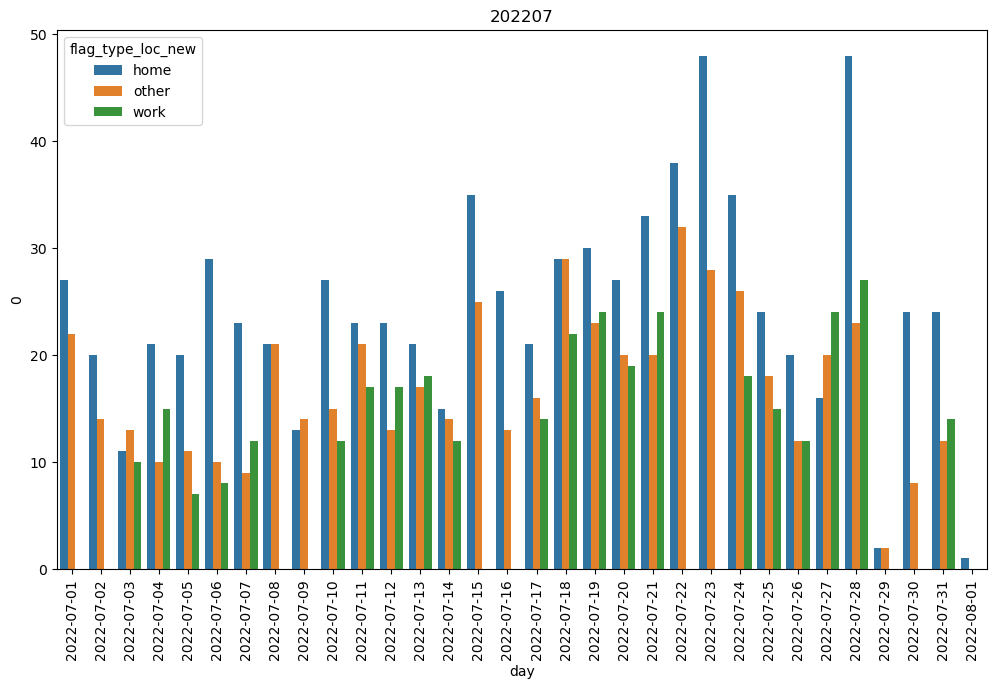

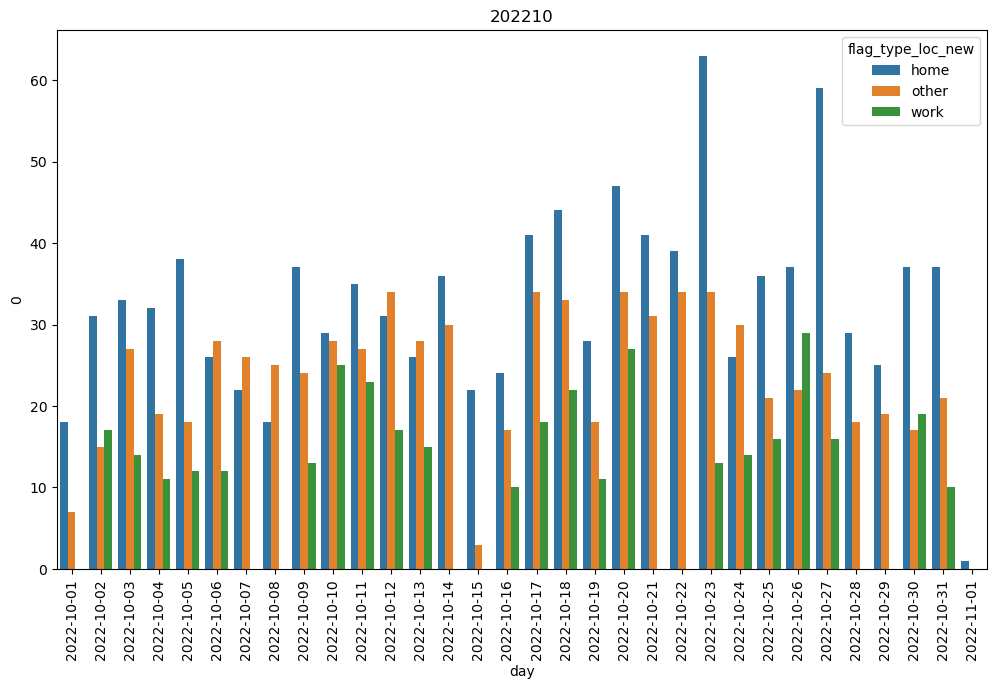

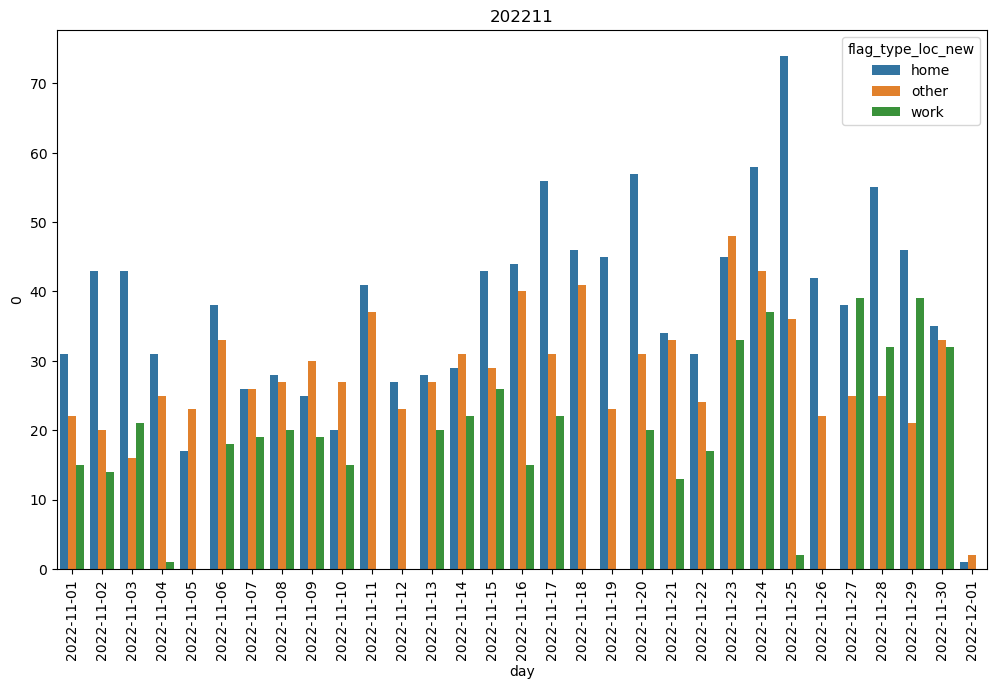

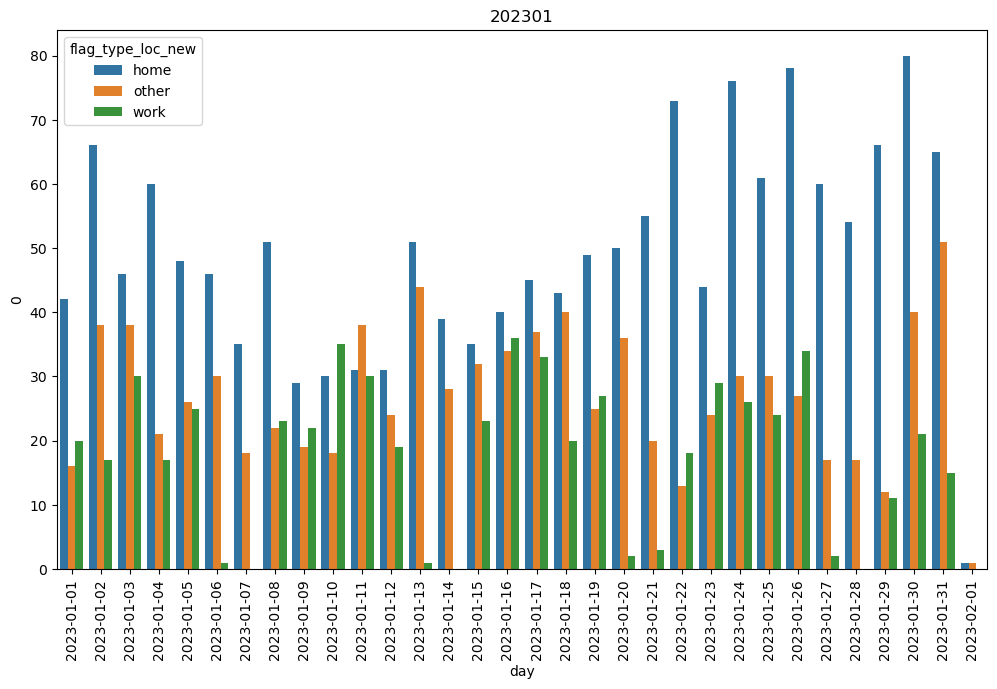

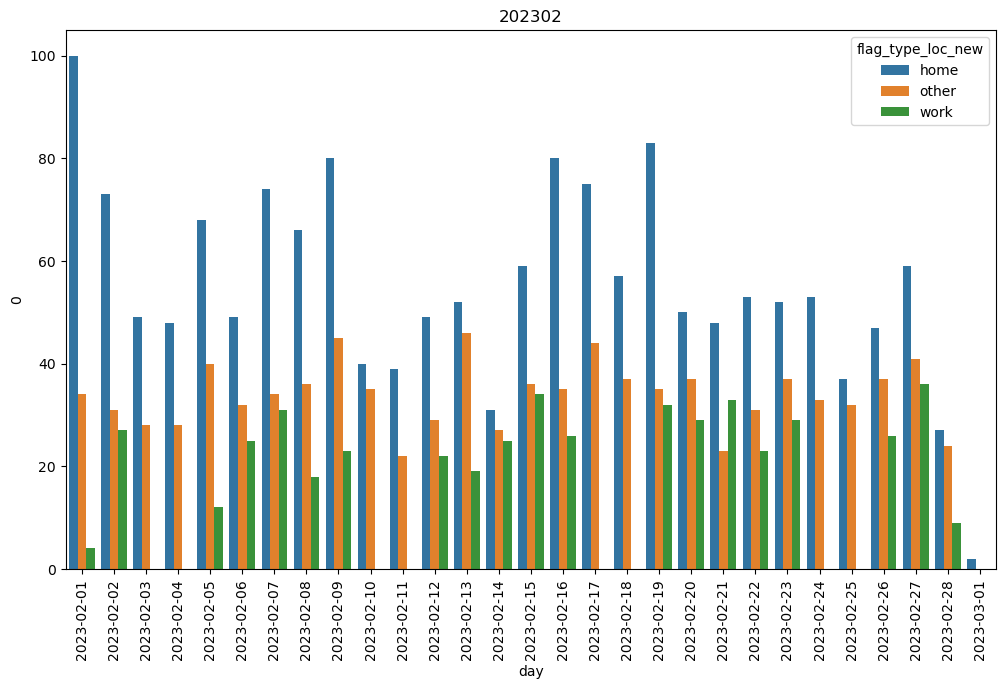

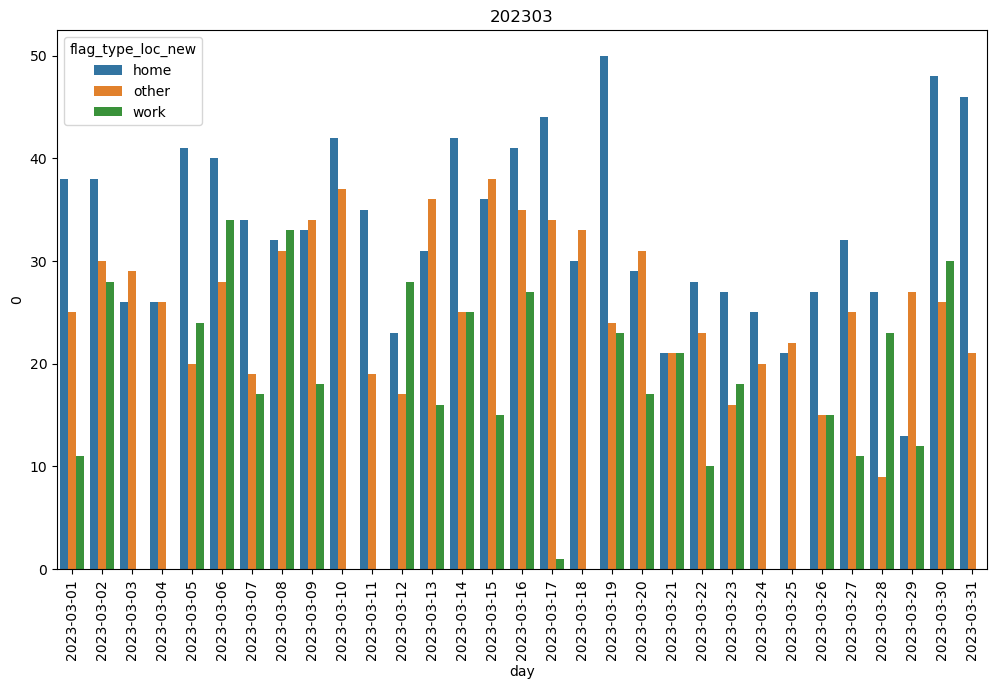

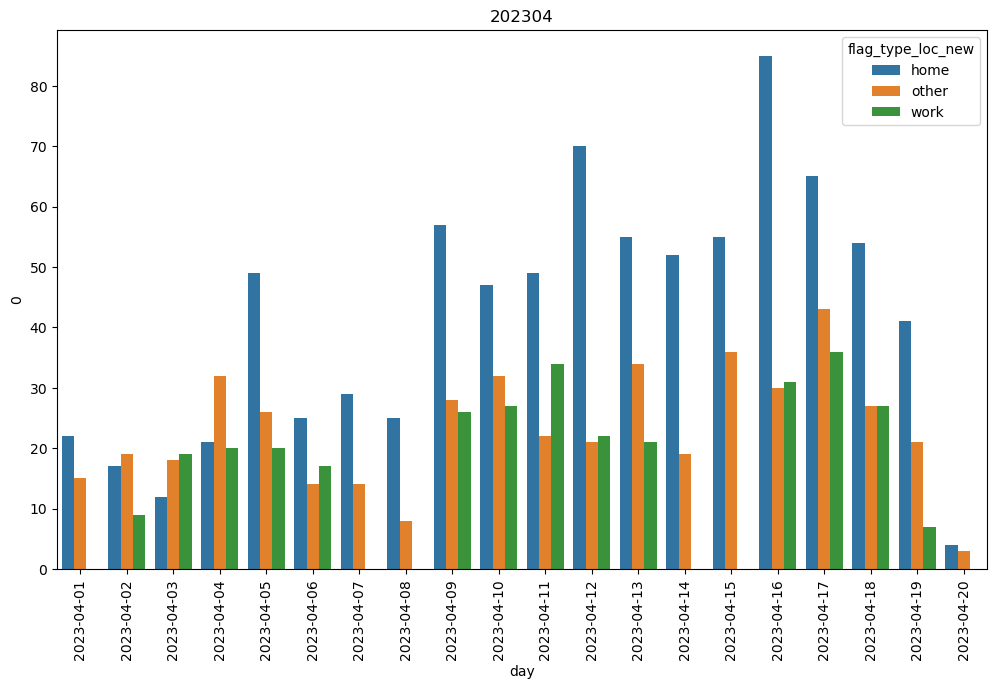

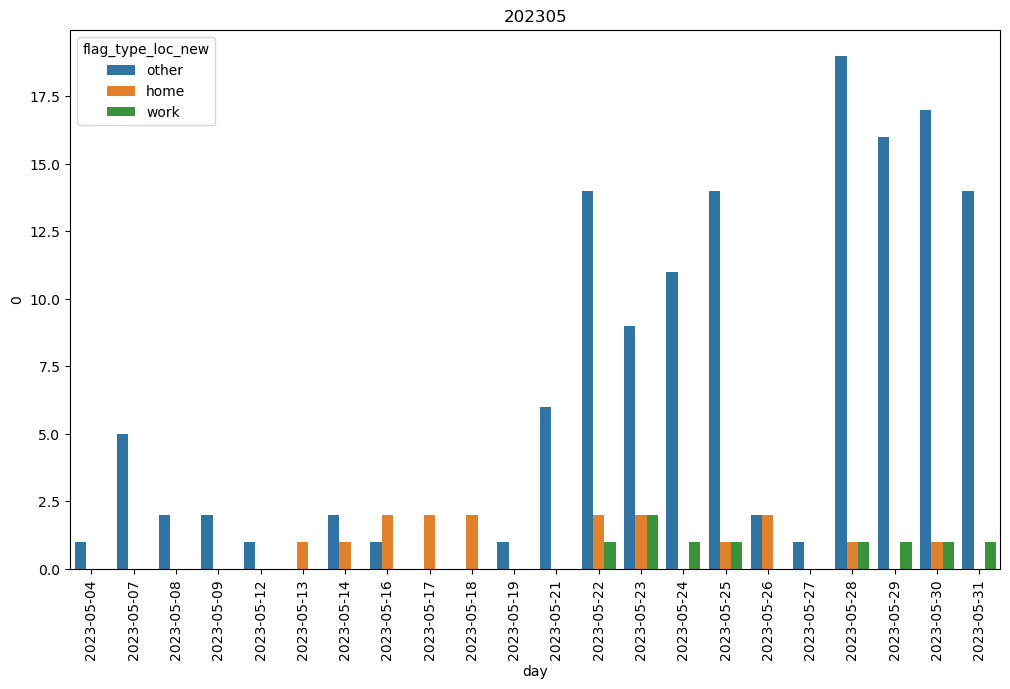

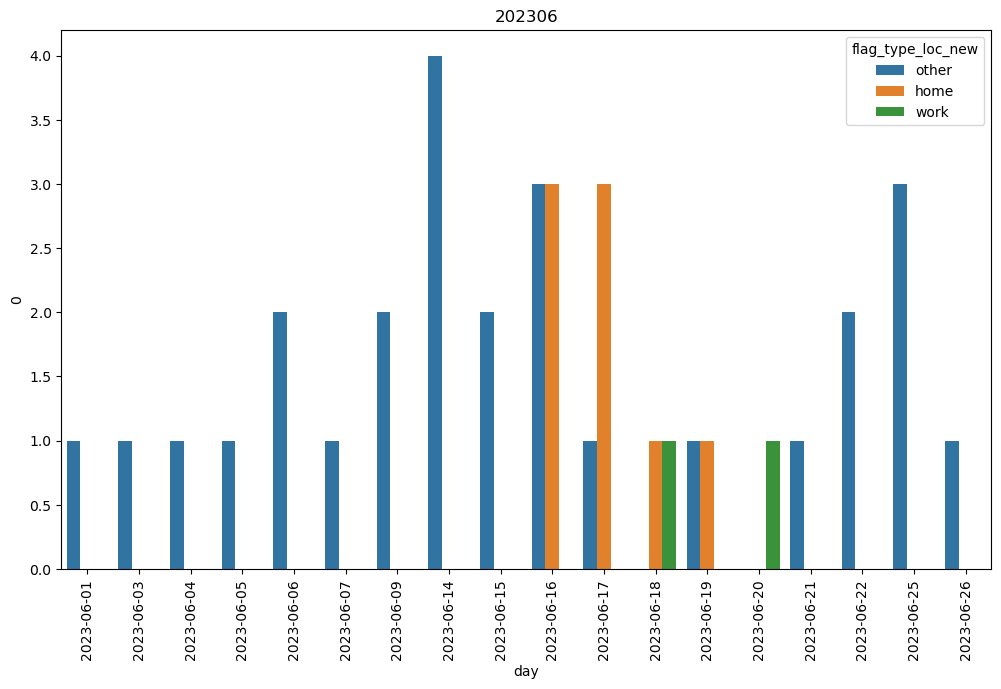

In [13]:
from matplotlib import pyplot as plt
import seaborn as sn

for month in df_freq_full_home_work.month.unique():
    plt.figure(figsize=(12, 7))
    df_freq = (
        df_freq_full_home_work[df_freq_full_home_work.month == month]
        .groupby(["day", "flag_type_loc_new"])
        .size()
        .reset_index()
    )
    sn.barplot(data=df_freq, x="day", y=0, hue="flag_type_loc_new")
    plt.title(month)
    plt.xticks(rotation="vertical")
    plt.show()

In [64]:
sample_work_hours = df_freq_full_home_work[
    (df_freq_full_home_work.identifier == "0353b2c6-fe26-430f-b1bb-6c5cc2a7b3e6")
    & (df_freq_full_home_work.flag_work_hours)
]

In [ ]:
sample_work_hours[sample_work_hours.month == "202009"][
    ["start_date_time", "the_geom", "geohash", "end_date_time", "flag_type_loc_new"]
].sort_values("start_date_time")

start_date_time                   the_geom  geohash  \
17143 2020-09-01 09:15:53   POINT (34.78647 32.0701)  swnvcu8   
16761 2020-09-01 15:10:11  POINT (34.78281 31.98829)  swntzuj   
20362 2020-09-01 16:52:17  POINT (34.78242 31.98374)  swntzgc   
15393 2020-09-01 17:01:25  POINT (34.78574 31.98677)  swntzus   
19826 2020-09-01 17:47:33  POINT (34.78719 31.98466)  swntzuf   
14137 2020-09-01 18:15:45  POINT (34.78273 31.98833)  swntzuj   
18108 2020-09-01 18:51:06  POINT (34.78822 31.98301)  swntzv1   
16695 2020-09-02 09:00:25  POINT (34.78473 32.06115)  swnvcs6   
18620 2020-09-02 09:11:47  POINT (34.78653 32.07017)  swnvcu8   
17641 2020-09-02 15:04:23  POINT (34.78649 32.06998)  swnvcu8   
18258 2020-09-02 16:19:59  POINT (34.78279 31.98827)  swntzuj   
14871 2020-09-02 17:20:55  POINT (34.78824 31.98299)  swntzv1   
17953 2020-09-02 17:53:18   POINT (34.7827 31.98835)  swntzgv   
14830 2020-09-02 18:00:50  POINT (34.78278 31.98828)  swntzuj   
19941 2020-09-03 09:13:40  POINT (34.78651 32.07012)  swnvcu8   
14338 2020-09-03 15:07:02  POINT (34.78669 32.06965)  swnvcu8   
19635 2020-09-03 15:54:59  POINT (34.78281 31.98442)  swntzu4   
16119 2020-09-03 16:06:25  POINT (34.78278 31.98829)  swntzuj   
17687 2020-09-06 09:29:20  POINT (34.78645 32.07006)  swnvcu8   
16586 2020-09-07 09:32:41  POINT (34.78643 32.07013)  swnvcu8   
16731 2020-09-07 15:16:36  POINT (34.78322 32.05198)  swnvck5   
14691 2020-09-07 15:23:25   POINT (34.78374 32.0502)  swnvck4   
18681 2020-09-07 15:37:08  POINT (34.76948 32.02206)  swnvb9t   
16801 2020-09-07 16:46:02   POINT (34.7828 31.98825)  swntzuj   
16717 2020-09-08 08:59:21  POINT (34.78648 32.07011)  swnvcu8   
18389 2020-09-08 15:04:12  POINT (34.78646 32.06998)  swnvcu8   
19609 2020-09-08 16:27:55   POINT (34.7834 32.05141)  swnvck5   
14838 2020-09-08 16:53:02  POINT (34.78259 31.98393)  swntzgc   
20369 2020-09-08 16:58:25  POINT (34.78281 31.98829)  swntzuj   
17384 2020-09-08 17:44:50   POINT (34.78279 31.9883)  swntzuj   
16494 2020-09-09 09:26:14   POINT (34.78918 32.0879)  swnvfjj   
14210 2020-09-09 09:45:28  POINT (34.78936 32.08796)  swnvfjj   
15422 2020-09-09 14:54:50  POINT (34.78651 32.06989)  swnvcu8   
15215 2020-09-09 16:08:44  POINT (34.78613 32.06472)  swnvcss   
16281 2020-09-09 16:38:04  POINT (34.78358 32.05064)  swnvck4   
15262 2020-09-09 17:09:28  POINT (34.78275 31.98834)  swntzuj   
14809 2020-09-10 08:34:57  POINT (34.77157 31.98154)  swntzcb   
18053 2020-09-10 09:23:22  POINT (34.78276 31.98833)  swntzuj   
17769 2020-09-10 16:36:47  POINT (34.78277 31.98829)  swntzuj   
20007 2020-09-10 17:26:05  POINT (34.80339 31.96629)  swntzrv   
20241 2020-09-10 18:01:55  POINT (34.78289 31.98823)  swntzuj   
17629 2020-09-10 18:06:33  POINT (34.78273 31.98834)  swntzuj   
16540 2020-09-13 08:00:16   POINT (34.78279 31.9883)  swntzuj   
14756 2020-09-13 10:33:04  POINT (34.74723 31.97905)  swntxtw   
17110 2020-09-15 14:57:38  POINT (34.78748 32.06864)  swnvcsz   
15357 2020-09-15 15:06:00  POINT (34.78748 32.06864)  swnvcsz   
16362 2020-09-15 15:14:10  POINT (34.78748 32.06864)  swnvcsz   
17763 2020-09-15 15:23:12  POINT (34.78644 32.07013)  swnvcu8   
15688 2020-09-15 15:57:17  POINT (34.78657 32.06944)  swnvcu8   
14752 2020-09-16 09:29:35   POINT (34.78641 32.0699)  swnvcu8   
14472 2020-09-16 11:03:30  POINT (34.78696 32.07088)  swnvcuc   
19999 2020-09-16 11:15:15  POINT (34.78589 32.06874)  swnvcsx   
20446 2020-09-16 11:38:31  POINT (34.78663 32.06981)  swnvcu8   
19186 2020-09-16 12:52:06  POINT (34.78678 32.06995)  swnvcu8   
20379 2020-09-16 16:35:41  POINT (34.78285 31.98828)  swntzuj   
19631 2020-09-17 09:02:55  POINT (34.78281 31.98822)  swntzuj   
15892 2020-09-20 07:13:13  POINT (34.78276 31.98833)  swntzuj   
15180 2020-09-23 12:36:36  POINT (34.78244 31.98381)  swntzgc   
16903 2020-09-24 07:10:27   POINT (34.7828 31.98835)  swntzuj   
16691 2020-09-24 15:07:43  POINT (34.78275 31.98833)  swntzuj   

            end_date_time flag_type_loc_new 

In [68]:
sample_work_hours.month.unique()

array(['202009', '202010', '202101', '202104', '202201', '202203',
       '202204', '202207', '202210', '202211', '202301', '202302',
       '202303', '202304'], dtype=object)

In [73]:
df_freq_home_work = df_freq_home_work.drop_duplicates(["identifier", "month"])

<Axes: xlabel='month'>

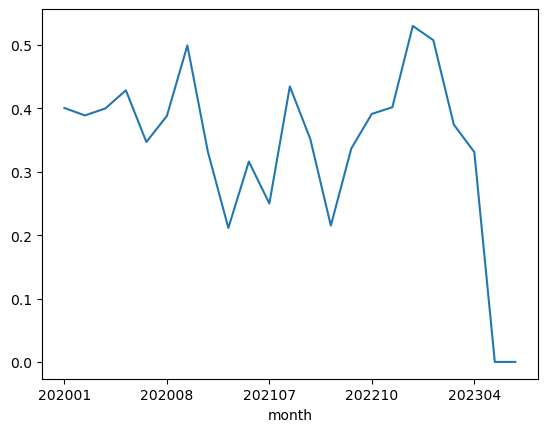

In [75]:
df_freq_home_work.groupby("month")["share_home_work_hours"].mean().plot()

<Axes: xlabel='month'>

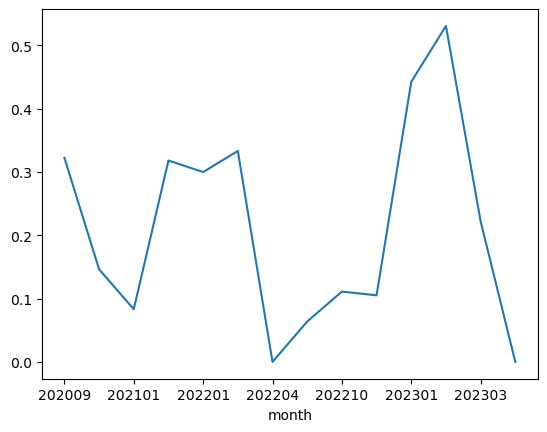

In [77]:
df_freq_home_work[
    df_freq_home_work.identifier == "0353b2c6-fe26-430f-b1bb-6c5cc2a7b3e6"
].groupby("month")["share_home_work_hours"].mean().plot()

In [72]:
df_freq_home_work[
    df_freq_home_work.identifier == "0353b2c6-fe26-430f-b1bb-6c5cc2a7b3e6"
].iloc[0]

identifier                                   0353b2c6-fe26-430f-b1bb-6c5cc2a7b3e6
date                                                                           25
work_location_date                                                              9
work_days_with_signals                                                         18
share_days_work_location                                                     0.36
share_workdays_work_location                                                  0.5
commuting_distance                                                    8832.786444
home_geometry                   POLYGON ((34.78271484375 31.988067626953125, 3...
geohash_home                                                              swntzuj
night_hours_count                                                            93.0
nights_count                                                                 23.0
rank_night                                                                    1.0
shabbat_hours_co

In [78]:
sample_work_hours.to_csv(
    utils.get_path("processed", "dwells", "frequent_user_example.csv")
)

In [66]:
sample_work_hours[sample_work_hours.month == "202009"][
    ["start_date_time", "the_geom", "geohash", "end_date_time", "flag_type_loc_new"]
].explore(column="flag_type_loc_new")

In [79]:
df_freq_home_work[
    df_freq_home_work.identifier == "0353b2c6-fe26-430f-b1bb-6c5cc2a7b3e6"
]

identifier  date  work_location_date  \
1189  0353b2c6-fe26-430f-b1bb-6c5cc2a7b3e6    25                   9   
455   0353b2c6-fe26-430f-b1bb-6c5cc2a7b3e6    26                   9   
524   0353b2c6-fe26-430f-b1bb-6c5cc2a7b3e6    23                  10   
393   0353b2c6-fe26-430f-b1bb-6c5cc2a7b3e6    21                   3   
358   0353b2c6-fe26-430f-b1bb-6c5cc2a7b3e6    16                   4   
555   0353b2c6-fe26-430f-b1bb-6c5cc2a7b3e6    23                   5   
382   0353b2c6-fe26-430f-b1bb-6c5cc2a7b3e6    20                   6   
878   0353b2c6-fe26-430f-b1bb-6c5cc2a7b3e6    25                  10   
1078  0353b2c6-fe26-430f-b1bb-6c5cc2a7b3e6    30                  11   
1407  0353b2c6-fe26-430f-b1bb-6c5cc2a7b3e6    28                  15   
1753  0353b2c6-fe26-430f-b1bb-6c5cc2a7b3e6    31                  19   
1860  0353b2c6-fe26-430f-b1bb-6c5cc2a7b3e6    28                  16   
2208  0353b2c6-fe26-430f-b1bb-6c5cc2a7b3e6    28                  10   
1047  0353b2c6-fe26-430f-b1bb-6c5cc2a7b3e6    11                   6   

      work_days_with_signals  share_days_work_location  \
1189                      18                  0.360000   
455                       17                  0.346154   
524                       15                  0.434783   
393                       14                  0.142857   
358                       11                  0.250000   
555                       19                  0.217391   
382                       15                  0.300000   
878                       17                  0.400000   
1078                      21                  0.366667   
1407                      20                  0.535714   
1753                      23                  0.612903   
1860                      20                  0.571429   
2208                      19                  0.357143   
1047                       9                  0.545455   

      share_workdays_work_location  commuting_distance  \
1189                      0.500000         8832.786444   
455                       0.529412         8832.786444   
524                       0.666667         8832.786444   
393                       0.214286         8832.786444   
358                       0.363636         8832.786444   
555                       0.263158         8832.786444   
382                       0.400000         8832.786444   
878                       0.588235         8832.786444   
1078                      0.523810         8832.786444   
1407                      0.750000         8832.786444   
1753                      0.826087         8832.786444   
1860                      0.800000         8832.786444   
2208                      0.526316         8832.786444   
1047                      0.666667         8832.786444   

                                          home_geometry geohash_home  \
1189  POLYGON ((34.78271484375 31.988067626953125, 3...      swntzuj   
455   POLYGON ((34.78271484375 31.988067626953125, 3...      swntzuj   
524   POLYGON ((34.78271484375 31.988067626953125, 3...      swntzuj   
393   POLYGON ((34.78271484375 31.988067626953125, 3...      swntzuj   
358   POLYGON ((34.78271484375 31.988067626953125, 3...      swntzuj   
555   POLYGON ((34.78271484375 31.988067626953125, 3...      swntzuj   
382   POLYGON ((34.78271484375 31.988067626953125, 3...      swntzuj   
878   POLYGON ((34.78271484375 31.988067626953125, 3...      swntzuj   
1078  POLYGON ((34.78271484375 31.988067626953125, 3...      swntzuj   
1407  POLYGON ((34.78271484375 31.988067626953125, 3...      swntzuj   
1753  POLYGON ((34.78271484375 31.988067626953125, 3...      swntzuj   
1860  POLYGON ((34.78271484375 31.988067626953125, 3...      swntzuj   
2208  POLYGON ((34.78271484375 31.988067626953125, 3...      swntzuj   
1047  POLYGON ((34.78271484375 31.988067626953125, 3...      swntzuj   

      night_hours_count  ...  date_work_all  share_work_in_home_hours  \
1189               93.0  ...           11.0            

Lets do a step back and check stability of data

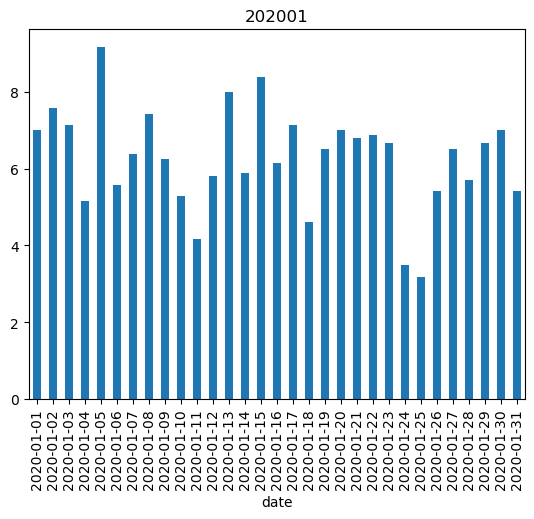

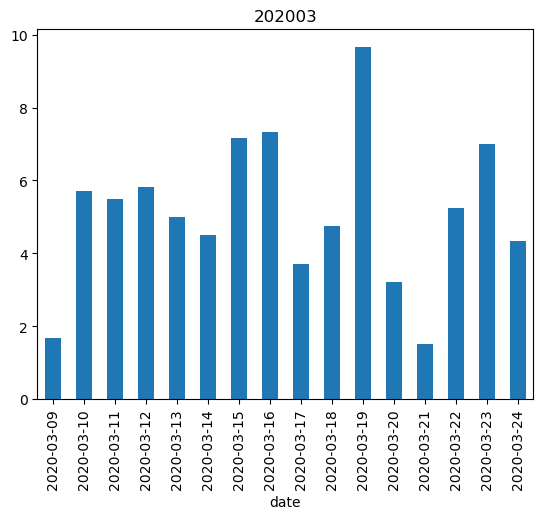

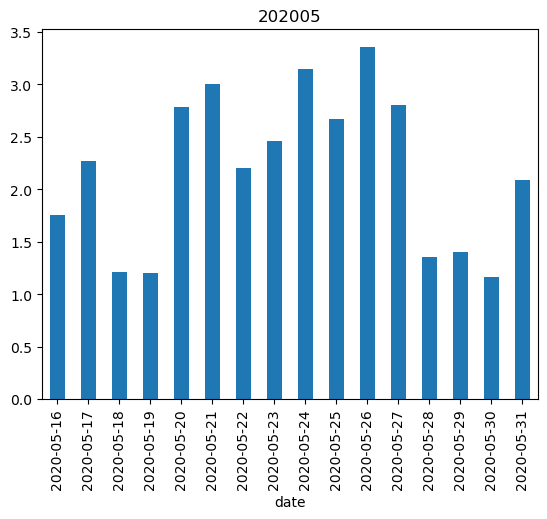

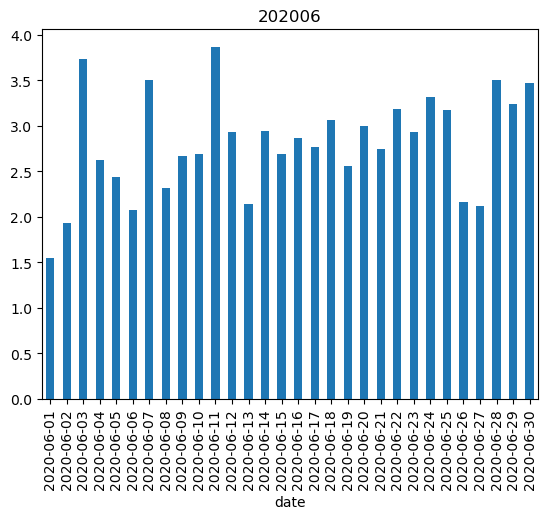

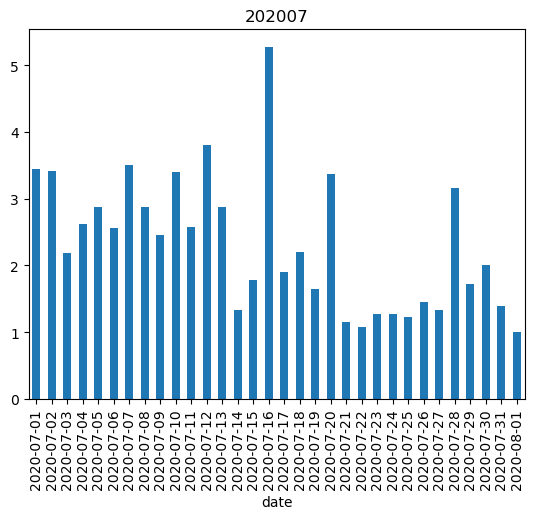

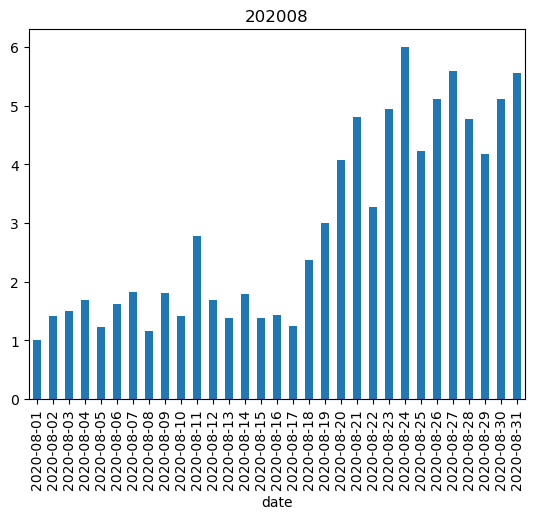

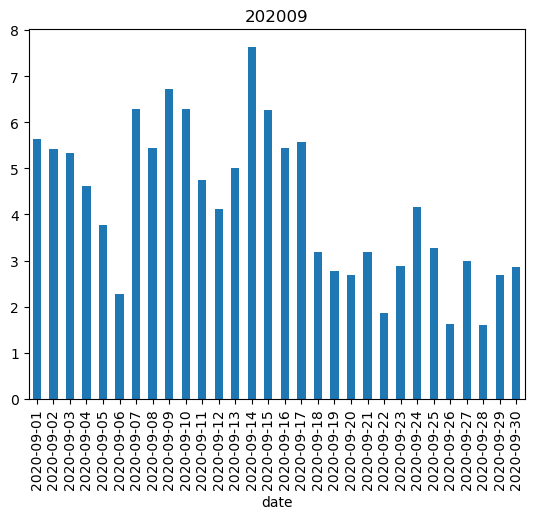

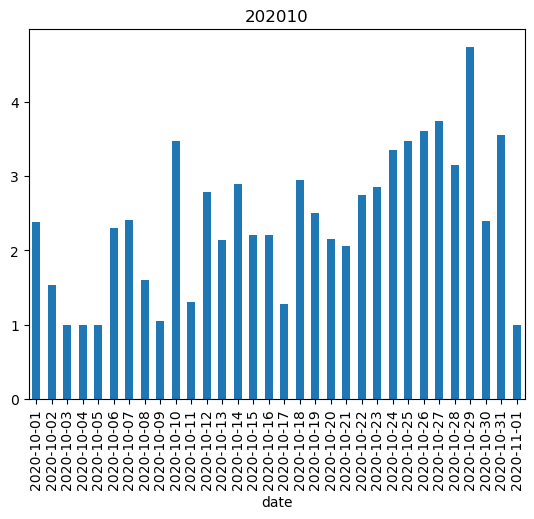

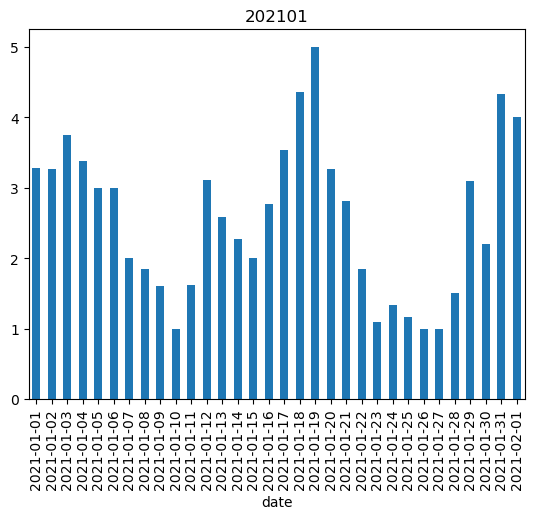

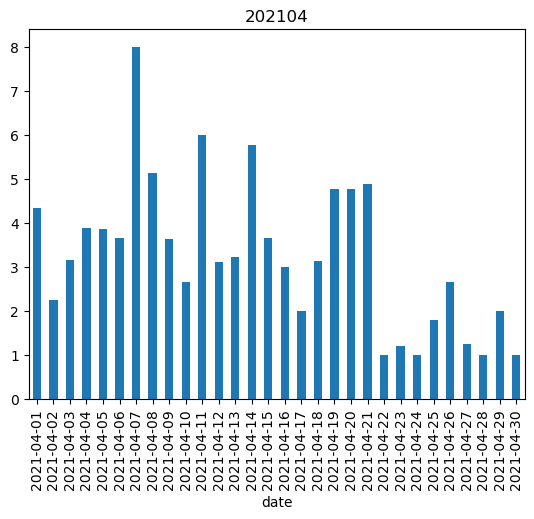

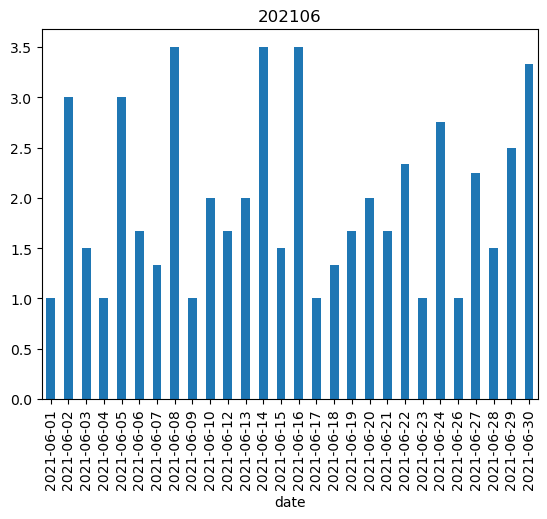

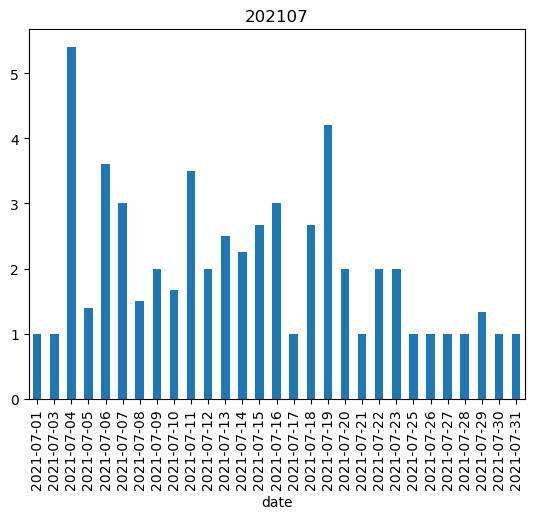

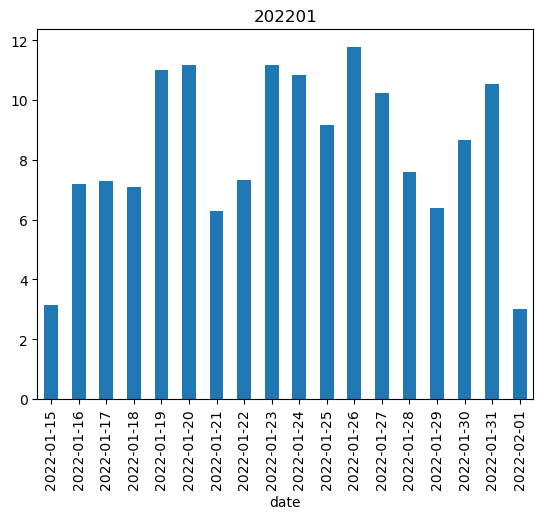

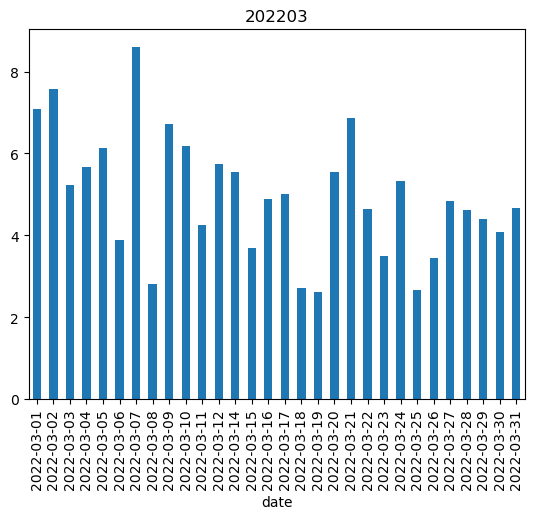

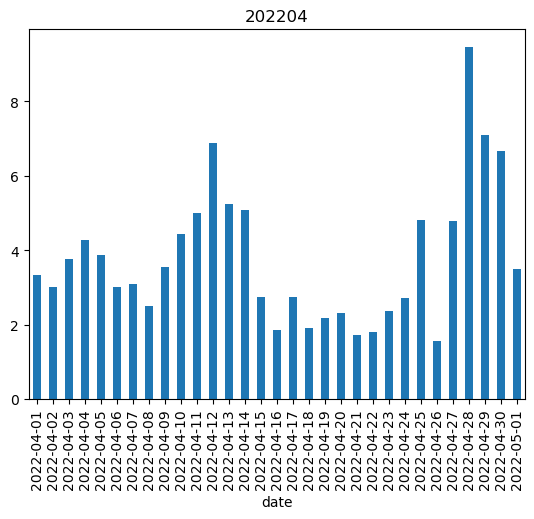

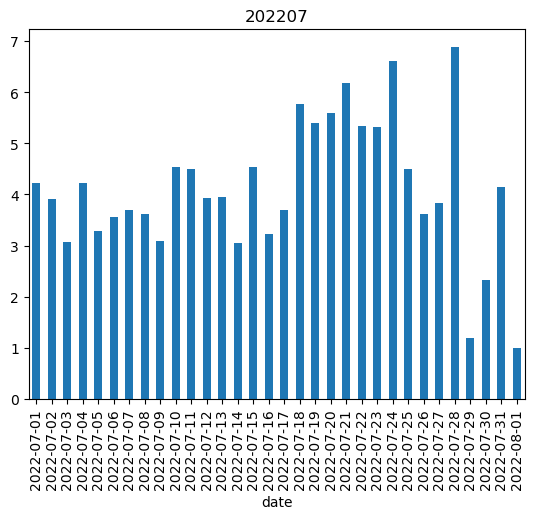

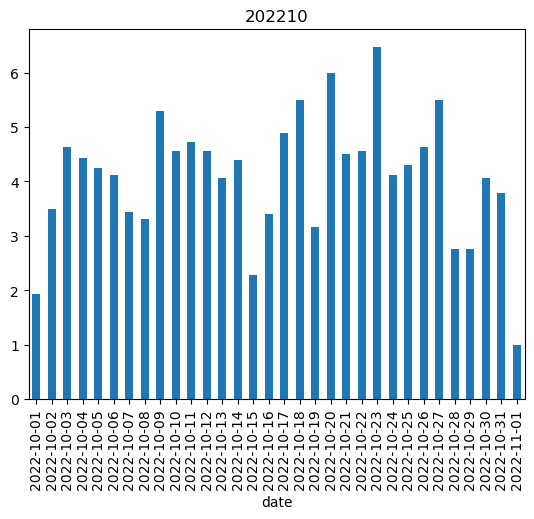

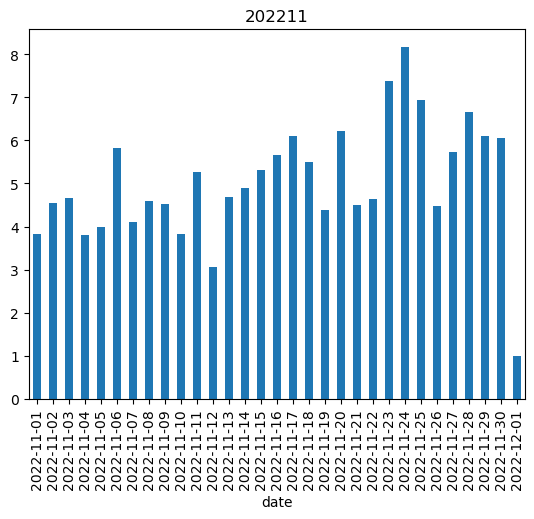

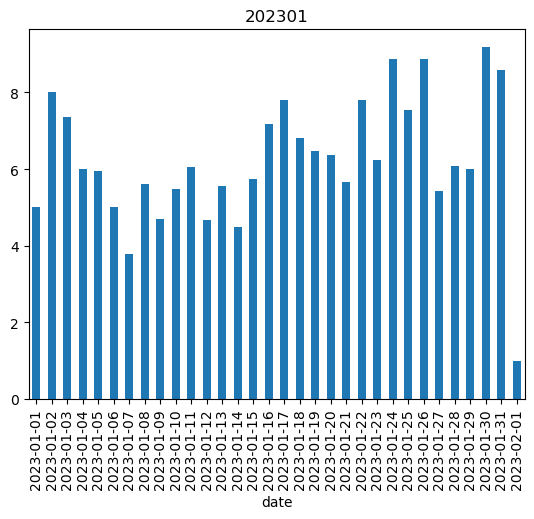

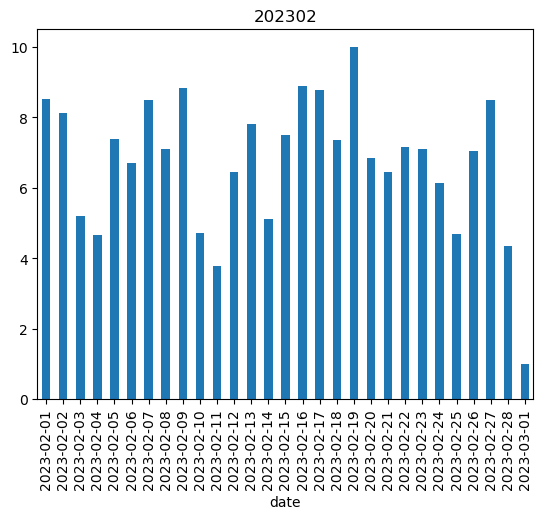

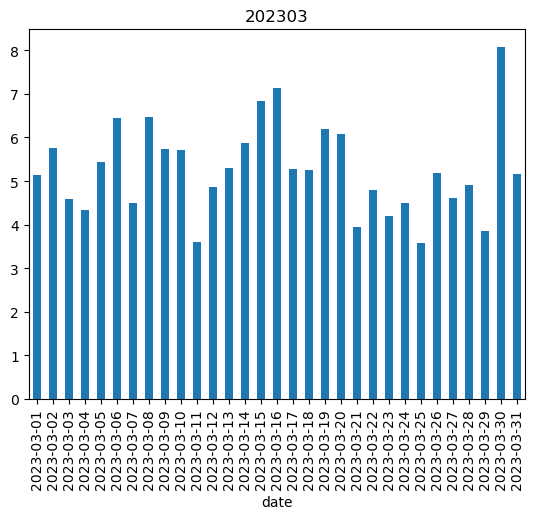

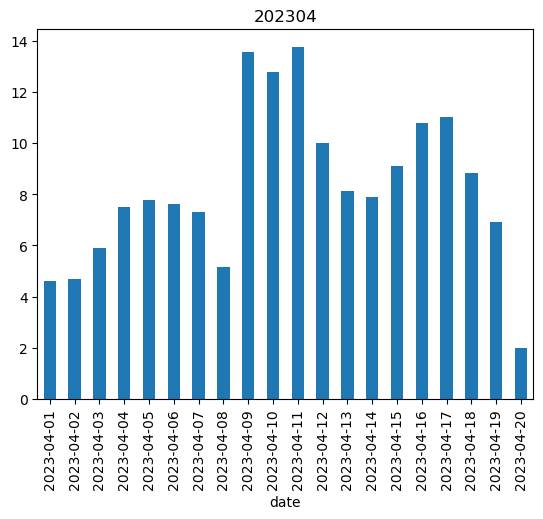

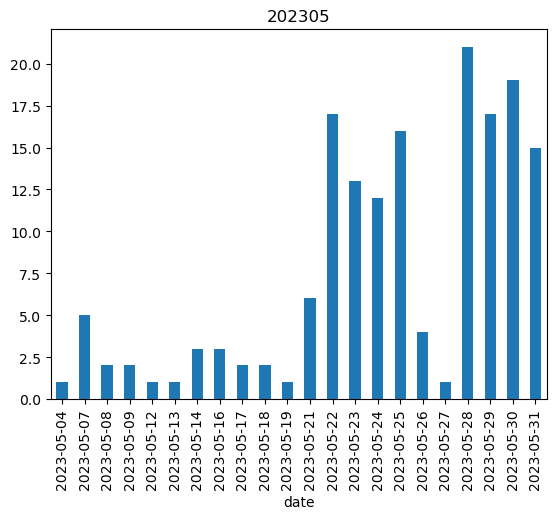

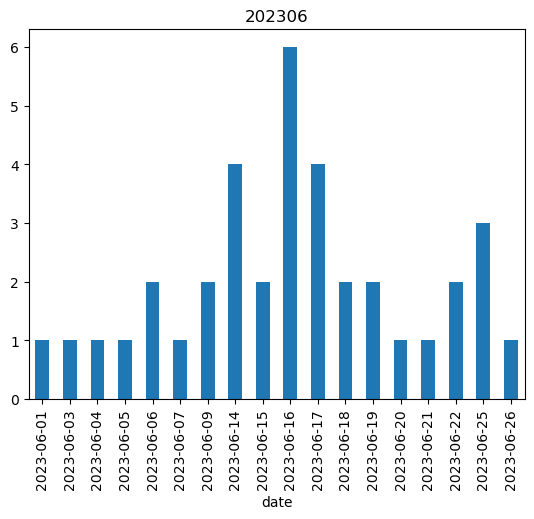

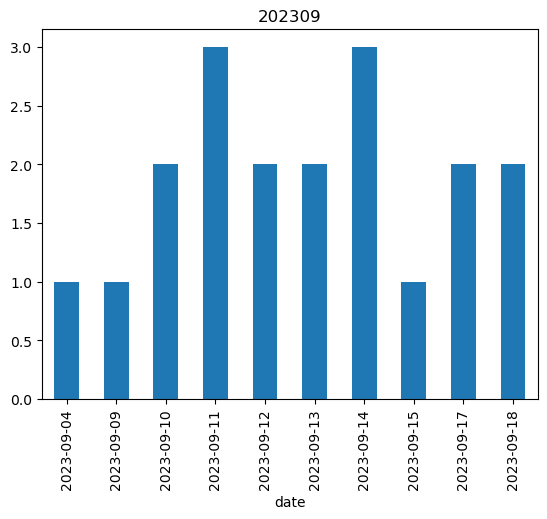

In [85]:
from matplotlib import pyplot as plt


for month in df_freq_full.month.unique():
    df_freq_full[df_freq_full.month == month].groupby(["date", "identifier"])[
        "geohash"
    ].count().groupby(level=0).mean().plot(kind="bar")
    plt.xticks(rotation="vertical")
    plt.title(month)
    plt.show()